In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### 1.0 Import the required libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler
from sklearn.linear_model import LassoCV,Lasso,LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import mean_squared_error,r2_score,make_scorer
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

##### 1.1 Data Inspection prior to Variable Encoding  

In [3]:
data_1 = pd.read_csv('/content/drive/MyDrive/Ijaz - Updated Files/Dissertation - Masters Project/Loan Interest Rate Prediction (ML Model Development)/Interest Rate Model Development - ML/interest_rate_non_engineered_df.csv')
display(data_1.shape) # (757263, 46)
display(data_1.head())

(757263, 46)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,27050.0,27050.0,27050.0,36 months,10.99,885.46,B,B2,10+ years,OWN,...,0.0,0.0,Jan-2016,885.46,Dec-2015,0.0,0.0,0.0,114834.0,59900.0
1,9750.0,9750.0,9750.0,36 months,13.98,333.14,C,C1,1 year,RENT,...,0.0,0.0,Jan-2016,333.14,Jan-2016,0.0,0.0,0.0,14123.0,15100.0
2,12000.0,12000.0,12000.0,36 months,6.62,368.45,A,A2,10+ years,MORTGAGE,...,0.0,0.0,Jan-2016,368.45,Jan-2016,0.0,0.0,0.0,267646.0,61100.0
3,12000.0,12000.0,12000.0,36 months,13.53,407.40,B,B5,10+ years,RENT,...,0.0,0.0,Sep-2015,119.17,Jan-2016,0.0,0.0,15386.0,13605.0,8100.0
4,15000.0,15000.0,15000.0,36 months,8.90,476.30,A,A5,2 years,MORTGAGE,...,0.0,0.0,Jan-2016,476.30,Jan-2016,0.0,0.0,1514.0,272492.0,15400.0


In [4]:
print(data_1.columns)

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim'],
      dtype='object')


##### 1.2 Seperate the Numerical and Categorical Features

In [5]:
num_cols = data_1.select_dtypes(include= ['float64','int64']).columns
cat_cols = data_1.select_dtypes(include= ['object']).columns
print(len(num_cols)) # 29 Numerical Variables
print(len(cat_cols)) # 17 Categorical Variables

29
17


##### 1.3 Numerical Feature Inspection and Scaling Check

In [6]:
# Inspect the data types of numerical features
# display(data_1[num_cols].dtypes)
# Inspect the number of unique values in numerical features.
# inq_last_6mths, collections_12_mths_ex_med and acc_now_delinq have relatively have very few unqiue
# values. From a technical perspective this can be treated as a categorical variable, however in the context
# of financial data, this is often considered as continuous since they represent either counts/proportions/incidents related
# to the credit history of borrowers.

# Strategy : Scale the numerical features using Standard Scaler.
display(data_1[num_cols].nunique())

,0
loan_amnt,1361
funded_amnt,1361
funded_amnt_inv,1397
int_rate,195
installment,61114
annual_inc,39925
dti,4000
delinq_2yrs,29
inq_last_6mths,9
open_acc,75


##### 1.4 Inspect the Categorical Features for Encoding

##### Seperate the variables (Inspect Cardinality and Irrelevance)

In [7]:
nunique_values_cat = data_1[cat_cols].nunique()

binary_variables = nunique_values_cat[nunique_values_cat < 3]
low_cardinality = nunique_values_cat[(nunique_values_cat >= 3) & (nunique_values_cat <= 10)]
moderate_cardinality = nunique_values_cat[(nunique_values_cat >= 11) & (nunique_values_cat <= 20)]
high_cardinality = nunique_values_cat[nunique_values_cat > 20]

##### A : Binary Variables (Less than 3 categories)

In [8]:
for i in binary_variables.index:
  print(data_1[i].value_counts())

# Strategy:
# The pymnt_plan variable can be dropped since its extremely biased towards borrowers
# who have not taken a payment plan (Extreme Class Imbalance).

# The term and initial_list_status have reasonable proportions and therefore they can
# be One-Hot encoded.

# term: One-Hot Encoding
# initial_list_status: One-Hot Encoding
# pymnt_plan: Exclude

term
 36 months    520912
 60 months    236351
Name: count, dtype: int64
pymnt_plan
n    757257
y         6
Name: count, dtype: int64
initial_list_status
w    394233
f    363030
Name: count, dtype: int64


##### B : Low Cardinality (3 to 10 Categories)

In [9]:
for i in low_cardinality.index:
  print(data_1[i].value_counts())

# Strategy:
# grade: Label Encoding
# home_ownership: One-Hot Encoding
# verification_status: One-Hot Encoding
# loan_status: One-Hot Encoding

grade
B    215696
C    213945
A    122505
D    119940
E     60992
F     19661
G      4524
Name: count, dtype: int64
home_ownership
MORTGAGE    383996
RENT        301204
OWN          71978
OTHER           42
NONE            41
ANY              2
Name: count, dtype: int64
verification_status
Source Verified    297354
Verified           231518
Not Verified       228391
Name: count, dtype: int64
loan_status
Current               556816
Fully Paid            148048
Charged Off            32711
Late (31-120 days)     10631
In Grace Period         5746
Late (16-30 days)       2149
Default                 1122
Issued                    40
Name: count, dtype: int64


##### C : Moderate Cardinality (11 to 20 categories)

In [10]:
for i in moderate_cardinality.index:
  print(data_1[i].value_counts())
# emp_length: Label Encoding
# purpose: One-Hot Encoding

emp_length
10+ years    268661
2 years       70007
3 years       62174
< 1 year      61472
1 year        50355
5 years       48653
4 years       45633
7 years       40542
8 years       40261
6 years       37859
9 years       31646
Name: count, dtype: int64
purpose
debt_consolidation    455902
credit_card           180550
home_improvement       42795
other                  33195
major_purchase         12973
small_business          7023
medical                 6688
car                     6168
moving                  4162
vacation                3742
house                   2806
wedding                  858
renewable_energy         400
educational                1
Name: count, dtype: int64


##### D : High Cardinality (Greater than 20 Categories)

In [11]:
print(high_cardinality)

# title: Exclude
# zip_code: Exclude

# sub_grade: Label Encoding
# issue_d: Label Encoding
# addr_state: One-Hot Encoding
# earliest_cr_line: Label Encoding
# last_pymnt_d: Label Encoding
# last_credit_pull_d: Label Encoding

sub_grade                35
issue_d                  41
title                 37424
zip_code                928
addr_state               51
earliest_cr_line        677
last_pymnt_d             41
last_credit_pull_d       42
dtype: int64


In [12]:
# Encoding Strategy

# Exclude:
# pymnt_plan
# title
# zip_code

# One-Hot Encoding:
# term
# home_ownership
# verification_status
# loan_status
# purpose
# addr_state
# initial_list_status

# Label Encoding:
# grade
# sub_grade
# emp_length
# issue_d
# earliest_cr_line
# last_pymnt_d
# last_credit_pull_d

In [13]:
# print(data_1.info())

##### 1.5 Data Preparation (Feature Selection and Machine Learning Model Development)

In [14]:
print(data_1['emp_length'].unique())

['10+ years' '1 year' '2 years' '4 years' '3 years' '7 years' '5 years'
 '6 years' '9 years' '8 years' '< 1 year']


In [15]:
# Create a copy of the data frame so that the original data frame is preserved
encoded_data = data_1.copy()

# Define the variables that should be kept based on your selections, including 'int_rate'
selected_vars = [
    'int_rate', 'loan_amnt', 'installment', 'annual_inc', 'dti', 'revol_util',
    'out_prncp', 'total_rec_int', 'last_pymnt_amnt', 'collection_recovery_fee',
    'delinq_2yrs', 'inq_last_6mths', 'pub_rec', 'collections_12_mths_ex_med',
    'acc_now_delinq', 'open_acc', 'emp_length', 'term', 'sub_grade',
    'home_ownership', 'verification_status', 'loan_status',
    'addr_state', 'purpose', 'initial_list_status'
]

# Retain only the selected variables in the data frame
encoded_data = encoded_data[selected_vars]

# Define the numerical variables (Continuous and Discrete)
numerical_cols = [
    'loan_amnt', 'installment', 'annual_inc', 'dti', 'revol_util',
    'out_prncp', 'total_rec_int', 'last_pymnt_amnt', 'collection_recovery_fee',
    'delinq_2yrs', 'inq_last_6mths', 'pub_rec', 'collections_12_mths_ex_med',
    'acc_now_delinq', 'open_acc'
]

# Define the categorical variables for Label Encoding and One-Hot Encoding
label_encode_cols = ['sub_grade', 'emp_length']  # Ordinal variables
one_hot_encode_cols = ['term', 'home_ownership', 'verification_status',
                       'loan_status', 'purpose', 'addr_state', 'initial_list_status']  # Nominal variables

# Apply Label Encoding to the ordinal categorical variables
label_encoders = {col: LabelEncoder() for col in label_encode_cols}
for col in label_encode_cols:
    encoded_data[col] = label_encoders[col].fit_transform(encoded_data[col])

# Apply One-Hot Encoding to the nominal categorical variables
encoded_data = pd.get_dummies(encoded_data, columns=one_hot_encode_cols)

# Print the final shape of the processed dataset
print("Dimensions of the Processed Data:", encoded_data.shape)
display(encoded_data.head())

Dimensions of the Processed Data: (757263, 104)


,int_rate,loan_amnt,installment,annual_inc,dti,revol_util,out_prncp,total_rec_int,last_pymnt_amnt,collection_recovery_fee,...,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_f,initial_list_status_w
0,10.99,27050.0,885.46,55000.0,22.87,61.2,10018.90,4219.94,885.46,0.0,...,False,False,False,False,False,False,False,False,False,True
1,13.98,9750.0,333.14,26000.0,25.12,52.8,3710.96,1955.79,333.14,0.0,...,False,False,False,False,False,False,False,False,True,False
2,6.62,12000.0,368.45,105000.0,14.05,21.6,4266.62,1109.42,368.45,0.0,...,False,False,False,False,False,False,False,False,False,True
3,13.53,12000.0,407.40,40000.0,16.94,68.8,0.00,1359.78,119.17,0.0,...,False,False,False,False,False,False,False,False,False,True
4,8.90,15000.0,476.30,63000.0,16.51,74.2,5449.27,1880.47,476.30,0.0,...,False,False,False,False,False,False,False,False,False,True


##### 1.6 Feature Selection [Non-Engineered Data]

A : Train and Test Split (80% Training and 20% Testing)

In [16]:
# Split the data into training and test.
# The data is split in the ratio 80% for training and 20% for testing.

# Define the X [features] and Y [interest rate]
X = encoded_data.drop(columns = ['int_rate'])
y = encoded_data['int_rate']

# Split the data into training and test sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

# Scale the numerical variables
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Inspect the variables after scaling
display(pd.DataFrame(X_train,columns = numerical_cols).describe())

# Implement Lasso Regression with Cross validation and Determine the Best Alpha
lasso_cv = LassoCV(alphas = np.logspace(-4,4,100),cv = 10,random_state = 42,max_iter = 10000,tol = 1e-4,n_jobs = -1)
lasso_cv.fit(X_train,y_train)

best_alpha = lasso_cv.alpha_
print(f"Best Alpha found by LassoCV: {best_alpha}")

lasso_coefficients = pd.Series(lasso_cv.coef_,index = X.columns)

,loan_amnt,installment,annual_inc,dti,revol_util,out_prncp,total_rec_int,last_pymnt_amnt,collection_recovery_fee,delinq_2yrs,inq_last_6mths,pub_rec,collections_12_mths_ex_med,acc_now_delinq,open_acc
count,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05
mean,9.164888e-17,-2.028849e-16,-3.043859e-16,-1.513954e-16,1.101335e-16,-2.767881e-16,9.537864e-17,-6.751100e-17,4.363115e-18,-9.066366e-18,-3.605435e-17,6.474300e-18,2.083036e-17,-9.852196e-19,3.013423e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.676149e+00,-1.735904e+00,-1.067962e+00,-2.219927e+00,-2.368800e+00,-1.067540e+00,-8.642058e-01,-4.483564e-01,-8.124862e-02,-3.733687e-01,-6.998980e-01,-3.346165e-01,-1.093980e-01,-6.637074e-02,-2.009610e+00
25%,-7.529681e-01,-7.260911e-01,-4.335524e-01,-7.530925e-01,-7.313610e-01,-9.670941e-01,-6.356598e-01,-3.873075e-01,-8.124862e-02,-3.733687e-01,-6.998980e-01,-3.346165e-01,-1.093980e-01,-6.637074e-02,-7.032067e-01
50%,-1.375141e-01,-2.240675e-01,-1.765200e-01,-5.897637e-02,3.618835e-02,-1.858531e-01,-3.247340e-01,-3.517693e-01,-8.124862e-02,-3.733687e-01,-6.998980e-01,-3.346165e-01,-1.093980e-01,-6.637074e-02,-1.433194e-01
75%,5.726251e-01,5.640323e-01,2.097715e-01,7.089048e-01,7.738886e-01,6.179867e-01,2.423019e-01,-2.821047e-01,-8.124862e-02,-3.733687e-01,3.427267e-01,-3.346165e-01,-1.093980e-01,-6.637074e-02,4.165679e-01
max,2.347973e+00,4.079669e+00,1.400027e+02,2.615910e+00,3.568033e+01,3.058270e+00,9.893507e+00,7.015457e+00,1.058401e+02,3.344698e+01,7.641099e+00,1.425469e+02,1.425696e+02,1.731909e+02,1.460038e+01


Best Alpha found by LassoCV: 0.0001


##### B : Lasso Regression (Mean Squared Error and Alpha Convergence)

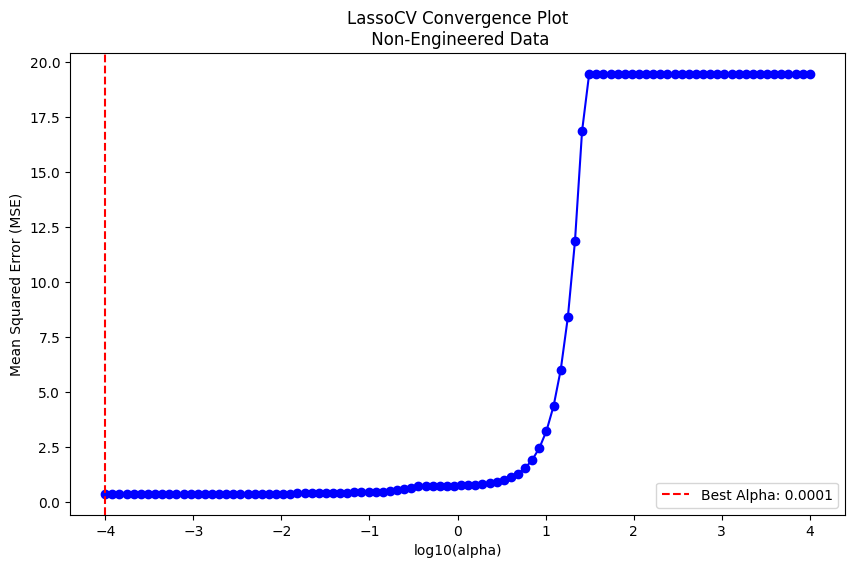

In [17]:
# Extract the Mean Squared Errors and Alphas
mse_path = lasso_cv.mse_path_.mean(axis = 1)
alphas = lasso_cv.alphas_

# Plot the Mean Squared Errors for each Alpha
plt.figure(figsize = (10,6))
plt.plot(np.log10(alphas),mse_path,marker = 'o',color = 'b')
plt.axvline(np.log10(best_alpha),linestyle = '--',color = 'r',label = f'Best Alpha: {best_alpha:.4f}')
plt.xlabel('log10(alpha)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('LassoCV Convergence Plot\n Non-Engineered Data')
plt.legend()
plt.show()

##### C : Feature Importance (Lasso Regression)

Number of Important features Selected by Lasso: 62
Important features:
 loan_amnt               -6.042014e-02
installment              1.157516e-01
annual_inc              -1.600912e-02
dti                     -2.346636e-02
revol_util               6.126158e-02
                             ...     
addr_state_TX            5.219532e-03
addr_state_WI           -7.562610e-03
addr_state_WV            8.042591e-03
initial_list_status_f    1.635899e-01
initial_list_status_w   -1.595222e-14
Length: 62, dtype: float64


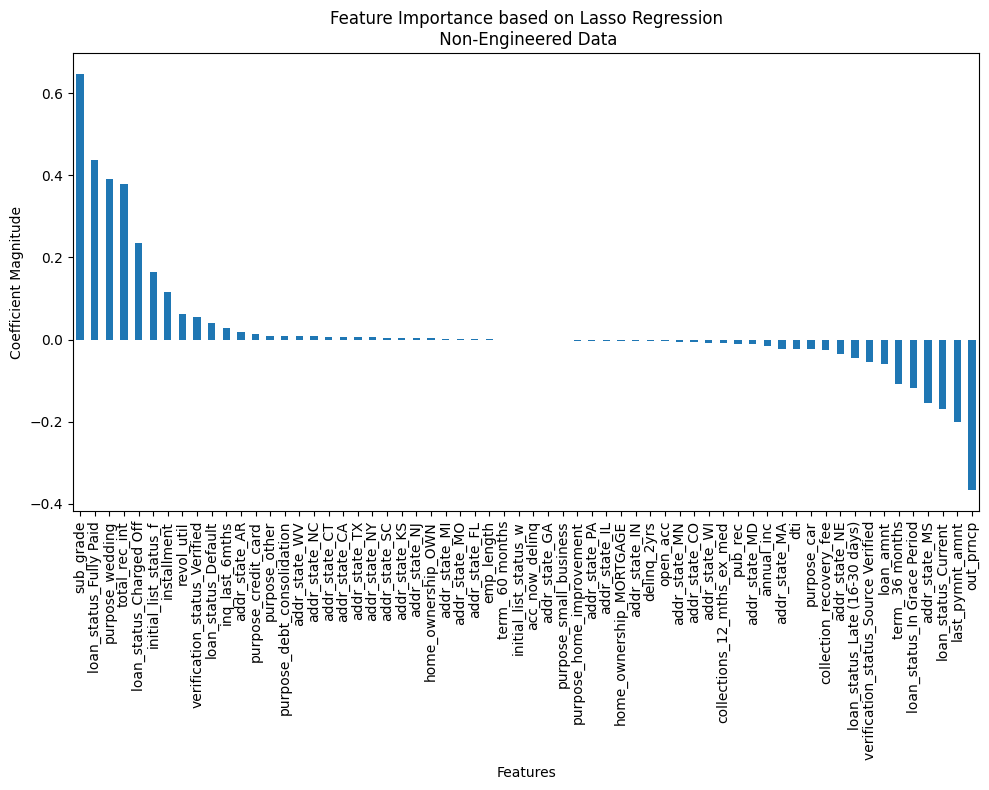

<Figure size 640x480 with 0 Axes>

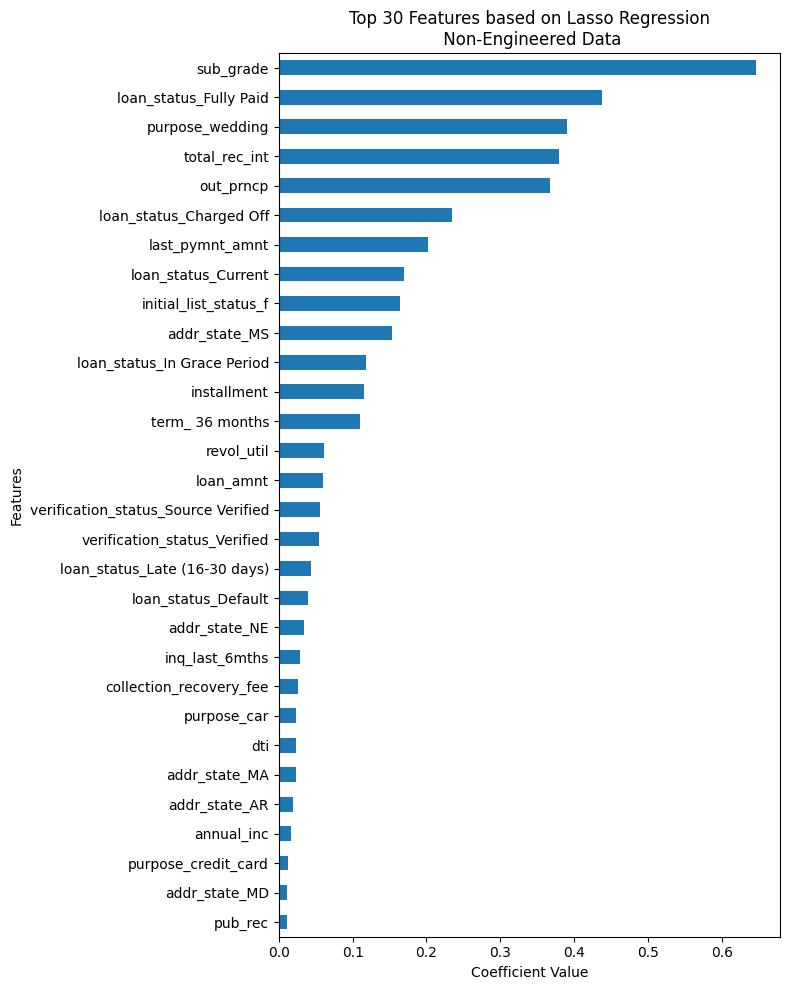

In [18]:
# Extract the important features selected by Lasso (non-zero coefficients)
important_features = lasso_coefficients[lasso_coefficients != 0]
print(f"Number of Important features Selected by Lasso: {len(important_features)}")

# Check if there are any important features
if len(important_features) > 0:
    print("Important features:\n", important_features)

    # Sort the important features by their coefficients
    important_features = important_features.sort_values(ascending=False)

    # Plot the Feature Importance
    plt.figure(figsize=(10,8))
    important_features.plot(kind='bar')
    plt.title("Feature Importance based on Lasso Regression\n Non-Engineered Data")
    plt.xlabel('Features')
    plt.ylabel('Coefficient Magnitude')
    plt.tight_layout()  # Ensure the layout is tight and labels are not cut off
    plt.show()
    plt.clf()

    # Plot the Top 30 Features obtained from Feature Importance
    top_30_features = lasso_coefficients.abs().sort_values(ascending=False).head(30)
    plt.figure(figsize=(8,10))
    top_30_features.sort_values().plot(kind='barh')
    plt.title('Top 30 Features based on Lasso Regression\n Non-Engineered Data')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Features')
    plt.tight_layout()  # Ensure the layout is tight and labels are not cut off
    plt.show()
else:
    print("No important features were selected by Lasso (all coefficients are zero).")

In [19]:
eliminated_features = lasso_coefficients[lasso_coefficients == 0]
print(len(eliminated_features))

41


##### D : Lasso Regression For Feature Importance (Training and Test Accuracy)

Train MSE: 0.37896820534148623
Test MSE: 0.3831815802236086
Train RMSE: 0.6156039354499663
Test RMSE: 0.6190166235438339
Train R2: 0.980524392133766
Test R2: 0.9803922065142197


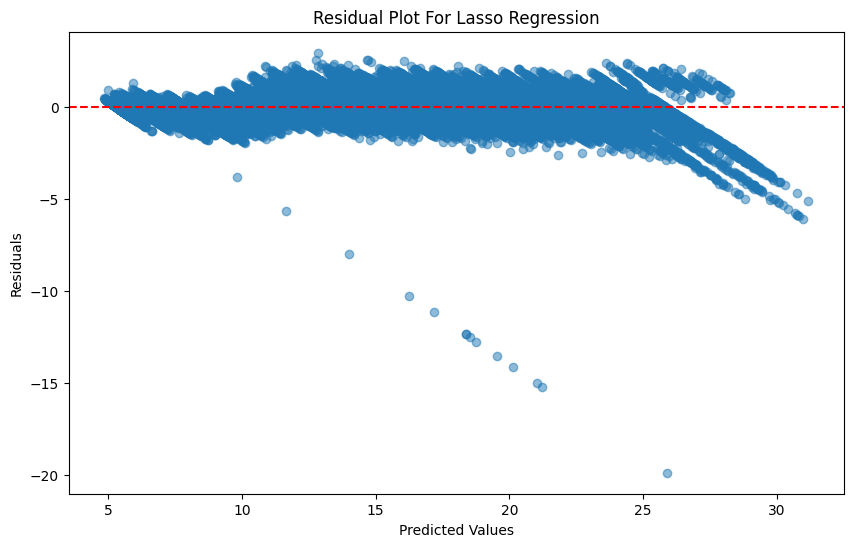

<Figure size 640x480 with 0 Axes>

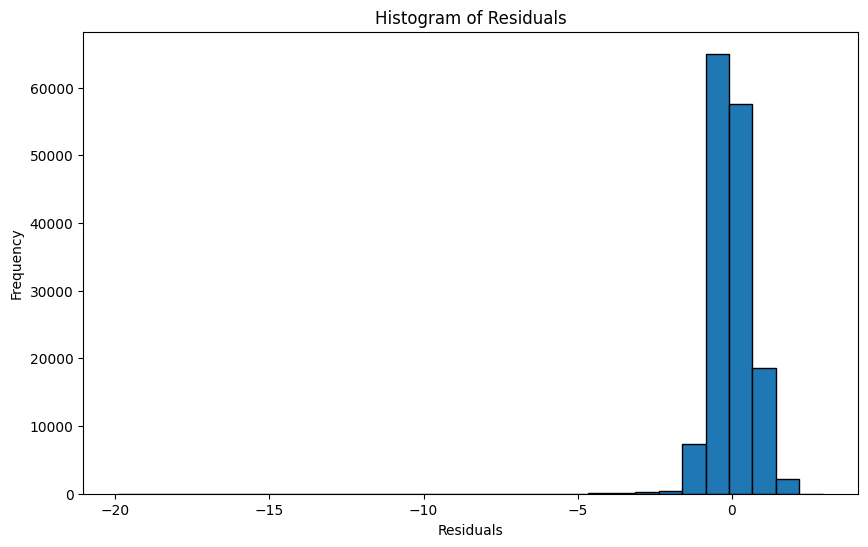

<Figure size 640x480 with 0 Axes>

In [20]:
# Determine the model pefromance on the training and testing data
y_train_pred = lasso_cv.predict(X_train)
y_test_pred = lasso_cv.predict(X_test)

# MSE of y_train_pred and y_test_pred
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

# RMSE of y_train_pred and y_test_pred
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

# R2 of y_train_pred and y_test_pred
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the results
print("Train MSE:", train_mse)
print("Test MSE:", test_mse)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

print("Train R2:", train_r2)
print("Test R2:", test_r2)


# Estimate the Residuals for the y_test_pred
residuals = y_test - y_test_pred

# Plot the Residuals for the y_test_pred
plt.figure(figsize = (10,6))
plt.scatter(y_test_pred,residuals,alpha = 0.5)
plt.axhline(y = 0,color = 'r',linestyle = '--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot For Lasso Regression')
plt.show()
plt.clf()

# Histogram of Residuals
plt.figure(figsize = (10,6))
plt.hist(residuals,bins = 30,edgecolor = 'k')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()
plt.clf()

In [21]:
# Inspect the variables for inspecting scaling
display(pd.DataFrame(X_train,columns = numerical_cols).describe())

,loan_amnt,installment,annual_inc,dti,revol_util,out_prncp,total_rec_int,last_pymnt_amnt,collection_recovery_fee,delinq_2yrs,inq_last_6mths,pub_rec,collections_12_mths_ex_med,acc_now_delinq,open_acc
count,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05
mean,9.164888e-17,-2.028849e-16,-3.043859e-16,-1.513954e-16,1.101335e-16,-2.767881e-16,9.537864e-17,-6.751100e-17,4.363115e-18,-9.066366e-18,-3.605435e-17,6.474300e-18,2.083036e-17,-9.852196e-19,3.013423e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.676149e+00,-1.735904e+00,-1.067962e+00,-2.219927e+00,-2.368800e+00,-1.067540e+00,-8.642058e-01,-4.483564e-01,-8.124862e-02,-3.733687e-01,-6.998980e-01,-3.346165e-01,-1.093980e-01,-6.637074e-02,-2.009610e+00
25%,-7.529681e-01,-7.260911e-01,-4.335524e-01,-7.530925e-01,-7.313610e-01,-9.670941e-01,-6.356598e-01,-3.873075e-01,-8.124862e-02,-3.733687e-01,-6.998980e-01,-3.346165e-01,-1.093980e-01,-6.637074e-02,-7.032067e-01
50%,-1.375141e-01,-2.240675e-01,-1.765200e-01,-5.897637e-02,3.618835e-02,-1.858531e-01,-3.247340e-01,-3.517693e-01,-8.124862e-02,-3.733687e-01,-6.998980e-01,-3.346165e-01,-1.093980e-01,-6.637074e-02,-1.433194e-01
75%,5.726251e-01,5.640323e-01,2.097715e-01,7.089048e-01,7.738886e-01,6.179867e-01,2.423019e-01,-2.821047e-01,-8.124862e-02,-3.733687e-01,3.427267e-01,-3.346165e-01,-1.093980e-01,-6.637074e-02,4.165679e-01
max,2.347973e+00,4.079669e+00,1.400027e+02,2.615910e+00,3.568033e+01,3.058270e+00,9.893507e+00,7.015457e+00,1.058401e+02,3.344698e+01,7.641099e+00,1.425469e+02,1.425696e+02,1.731909e+02,1.460038e+01


In [22]:
xgb_simple = xgb.XGBRegressor(random_state = 42)

xgb_simple.fit(X_train,y_train)

y_train_pred = xgb_simple.predict(X_train)
y_test_pred = xgb_simple.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print("Train RMSE:", train_rmse)
print("Train R2:", train_r2)

print("Test RMSE:", test_rmse)
print("Test R2:", test_r2)

Train RMSE: 0.3053926668755938
Train R2: 0.9952070217792383
Test RMSE: 0.31989367133150076
Test R2: 0.9947635688639119


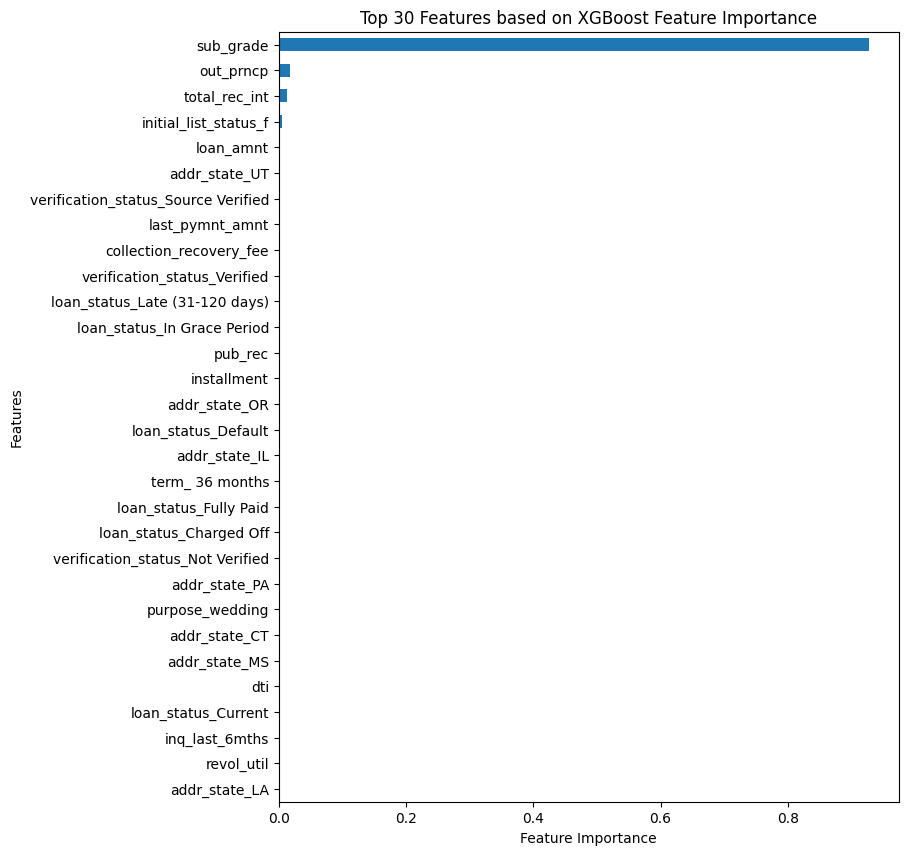

<Figure size 640x480 with 0 Axes>

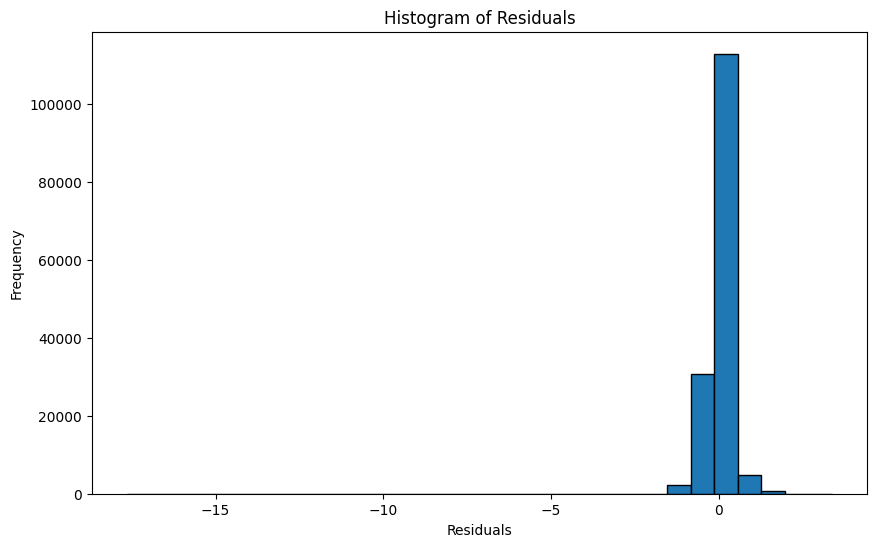

In [23]:
# Plot Feature Importance
xgb_importances = xgb_simple.feature_importances_

xgb_feature_importance = pd.Series(xgb_importances,index = X.columns)
top_30_xgb_features = xgb_feature_importance.sort_values(ascending = False).head(30)

# Plot the Top 30 Features obtained from Feature Importance
plt.figure(figsize = (8, 10))
top_30_xgb_features.sort_values().plot(kind = 'barh')
plt.title('Top 30 Features based on XGBoost Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()
plt.clf()

# Estimate the Residuals for xgb_simple
residuals = y_test - y_test_pred

# Histogram of Residuals
plt.figure(figsize = (10,6))
plt.hist(residuals,bins = 30,edgecolor = 'k')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

In [24]:
rmse_scorer = make_scorer(mean_squared_error,squared = False)

cv_scores = cross_val_score(xgb_simple,X_train,y_train,cv = 5,scoring = rmse_scorer,verbose = 1)

cv_r2_scores = cross_val_score(xgb_simple,X_train,y_train,cv = 5,scoring = 'r2',verbose = 1)

# Print the RMSE results
print(f"Cross-Validation RMSE Scores: {cv_scores}")
print(f"Mean CV RMSE: {np.mean(cv_scores)}")
print(f"Standard Deviation of CV RMSE: {np.std(cv_scores)}")

# Print the R2 results
print(f"Cross-Validation R2 Scores: {cv_r2_scores}")
print(f"Mean CV R2: {np.mean(cv_r2_scores)}")
print(f"Standard Deviation of CV R2: {np.std(cv_r2_scores)}")

Cross-Validation RMSE Scores: [0.3360267  0.31745384 0.32809301 0.32249462 0.31581109]
Mean CV RMSE: 0.32397585185824235
Standard Deviation of CV RMSE: 0.007396865512610603
Cross-Validation R2 Scores: [0.99418262 0.99482065 0.99446918 0.99467612 0.99486617]
Mean CV R2: 0.9946029492727909
Standard Deviation of CV R2: 0.00025163488976002226


In [25]:
display(X_train[numerical_cols].describe())

,loan_amnt,installment,annual_inc,dti,revol_util,out_prncp,total_rec_int,last_pymnt_amnt,collection_recovery_fee,delinq_2yrs,inq_last_6mths,pub_rec,collections_12_mths_ex_med,acc_now_delinq,open_acc
count,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05
mean,9.164888e-17,-2.028849e-16,-3.043859e-16,-1.513954e-16,1.101335e-16,-2.767881e-16,9.537864e-17,-6.751100e-17,4.363115e-18,-9.066366e-18,-3.605435e-17,6.474300e-18,2.083036e-17,-9.852196e-19,3.013423e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.676149e+00,-1.735904e+00,-1.067962e+00,-2.219927e+00,-2.368800e+00,-1.067540e+00,-8.642058e-01,-4.483564e-01,-8.124862e-02,-3.733687e-01,-6.998980e-01,-3.346165e-01,-1.093980e-01,-6.637074e-02,-2.009610e+00
25%,-7.529681e-01,-7.260911e-01,-4.335524e-01,-7.530925e-01,-7.313610e-01,-9.670941e-01,-6.356598e-01,-3.873075e-01,-8.124862e-02,-3.733687e-01,-6.998980e-01,-3.346165e-01,-1.093980e-01,-6.637074e-02,-7.032067e-01
50%,-1.375141e-01,-2.240675e-01,-1.765200e-01,-5.897637e-02,3.618835e-02,-1.858531e-01,-3.247340e-01,-3.517693e-01,-8.124862e-02,-3.733687e-01,-6.998980e-01,-3.346165e-01,-1.093980e-01,-6.637074e-02,-1.433194e-01
75%,5.726251e-01,5.640323e-01,2.097715e-01,7.089048e-01,7.738886e-01,6.179867e-01,2.423019e-01,-2.821047e-01,-8.124862e-02,-3.733687e-01,3.427267e-01,-3.346165e-01,-1.093980e-01,-6.637074e-02,4.165679e-01
max,2.347973e+00,4.079669e+00,1.400027e+02,2.615910e+00,3.568033e+01,3.058270e+00,9.893507e+00,7.015457e+00,1.058401e+02,3.344698e+01,7.641099e+00,1.425469e+02,1.425696e+02,1.731909e+02,1.460038e+01


Simple XG Boost (With and Without Subgrade)

With sub_grade:
Train RMSE: 0.3053926668755938, Train R2: 0.9952070217792383
Test RMSE: 0.31989367133150076, Test R2: 0.9947635688639119

Without sub_grade:
Train RMSE: 1.0091595472834438, Train R2: 0.9476631098863502
Test RMSE: 1.042672539075976, Test R2: 0.9443686023063194


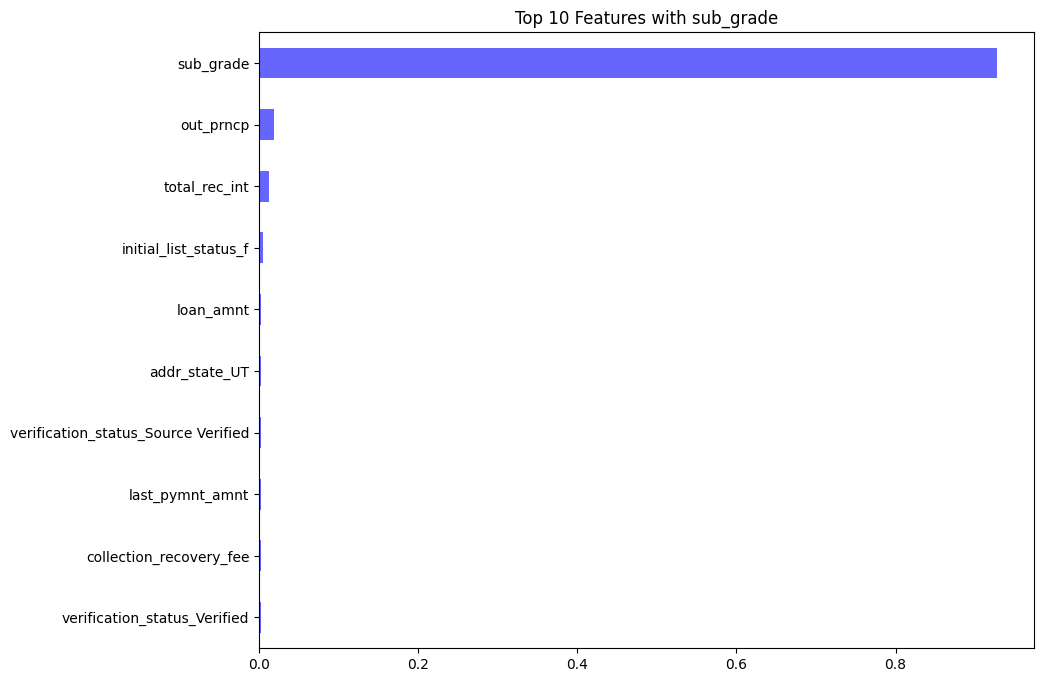

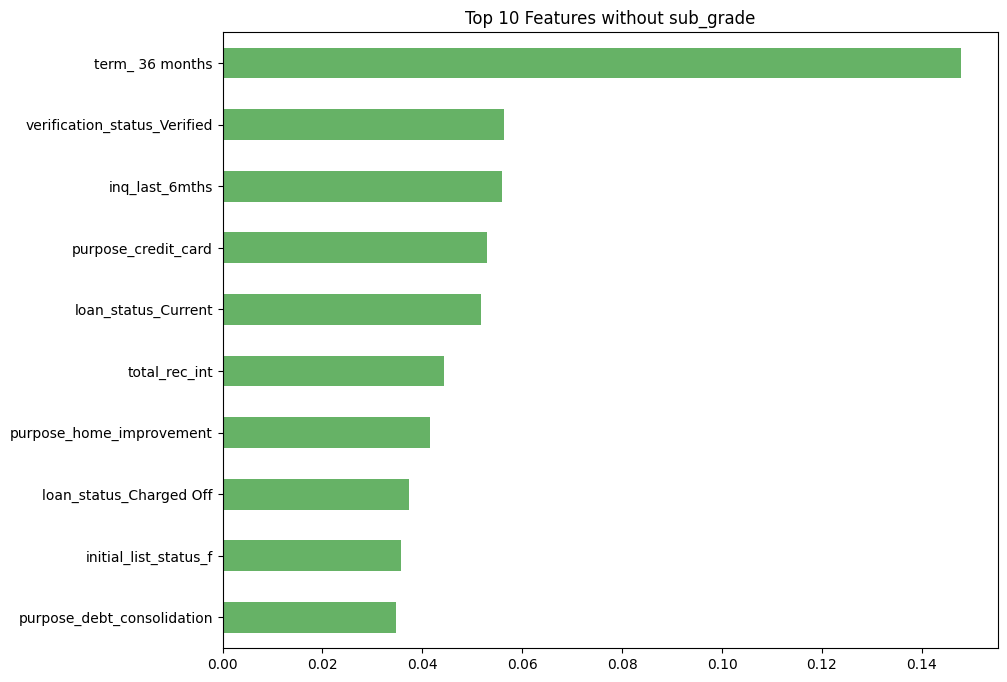

In [26]:
# 1. Create a copy of the dataset without `sub_grade`
X_train_without_sub_grade = X_train.drop(columns=['sub_grade'])
X_test_without_sub_grade = X_test.drop(columns=['sub_grade'])

# 2. Train the model with `sub_grade`
xgb_with_sub_grade = xgb.XGBRegressor(random_state=42)
xgb_with_sub_grade.fit(X_train, y_train)

# 3. Train the model without `sub_grade`
xgb_without_sub_grade = xgb.XGBRegressor(random_state=42)
xgb_without_sub_grade.fit(X_train_without_sub_grade, y_train)

# 4. Predict and calculate metrics for the model with `sub_grade`
y_train_pred_with = xgb_with_sub_grade.predict(X_train)
y_test_pred_with = xgb_with_sub_grade.predict(X_test)

train_rmse_with = np.sqrt(mean_squared_error(y_train, y_train_pred_with))
test_rmse_with = np.sqrt(mean_squared_error(y_test, y_test_pred_with))
train_r2_with = r2_score(y_train, y_train_pred_with)
test_r2_with = r2_score(y_test, y_test_pred_with)

# 5. Predict and calculate metrics for the model without `sub_grade`
y_train_pred_without = xgb_without_sub_grade.predict(X_train_without_sub_grade)
y_test_pred_without = xgb_without_sub_grade.predict(X_test_without_sub_grade)

train_rmse_without = np.sqrt(mean_squared_error(y_train, y_train_pred_without))
test_rmse_without = np.sqrt(mean_squared_error(y_test, y_test_pred_without))
train_r2_without = r2_score(y_train, y_train_pred_without)
test_r2_without = r2_score(y_test, y_test_pred_without)

# 6. Print the comparison of performance metrics
print("With sub_grade:")
print(f"Train RMSE: {train_rmse_with}, Train R2: {train_r2_with}")
print(f"Test RMSE: {test_rmse_with}, Test R2: {test_r2_with}")

print("\nWithout sub_grade:")
print(f"Train RMSE: {train_rmse_without}, Train R2: {train_r2_without}")
print(f"Test RMSE: {test_rmse_without}, Test R2: {test_r2_without}")

# 7. (Optional) Plot the Feature Importance for both models
# With sub_grade
xgb_importances_with = xgb_with_sub_grade.feature_importances_
xgb_feature_importance_with = pd.Series(xgb_importances_with, index=X_train.columns)

# Without sub_grade
xgb_importances_without = xgb_without_sub_grade.feature_importances_
xgb_feature_importance_without = pd.Series(xgb_importances_without, index=X_train_without_sub_grade.columns)

# Plot Feature Importance for both models
plt.figure(figsize=(10, 8))
xgb_feature_importance_with.sort_values().tail(10).plot(kind='barh', color='blue', alpha=0.6)
plt.title('Top 10 Features with sub_grade')

plt.figure(figsize=(10, 8))
xgb_feature_importance_without.sort_values().tail(10).plot(kind='barh', color='green', alpha=0.6)
plt.title('Top 10 Features without sub_grade')

plt.show()

Tree Split (Simple XG Boost --> With and Without Sub-Grade)

In [27]:
# 8. Plot a tree from the model with `sub_grade`

from xgboost import plot_tree

# Set up the figure and axis
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 30))  # Two subplots side by side

# 1st tree with sub_grade
plot_tree(xgb_with_sub_grade, num_trees=0, rankdir='LR', ax=axes[0])
axes[0].set_title('XGBoost Tree with sub_grade', fontsize=16)

# 2nd tree without sub_grade
plot_tree(xgb_without_sub_grade, num_trees=0, rankdir='LR', ax=axes[1])
axes[1].set_title('XGBoost Tree without sub_grade', fontsize=16)

# Display the plots
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [28]:
display(X_train[numerical_cols].describe())

,loan_amnt,installment,annual_inc,dti,revol_util,out_prncp,total_rec_int,last_pymnt_amnt,collection_recovery_fee,delinq_2yrs,inq_last_6mths,pub_rec,collections_12_mths_ex_med,acc_now_delinq,open_acc
count,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05
mean,9.164888e-17,-2.028849e-16,-3.043859e-16,-1.513954e-16,1.101335e-16,-2.767881e-16,9.537864e-17,-6.751100e-17,4.363115e-18,-9.066366e-18,-3.605435e-17,6.474300e-18,2.083036e-17,-9.852196e-19,3.013423e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.676149e+00,-1.735904e+00,-1.067962e+00,-2.219927e+00,-2.368800e+00,-1.067540e+00,-8.642058e-01,-4.483564e-01,-8.124862e-02,-3.733687e-01,-6.998980e-01,-3.346165e-01,-1.093980e-01,-6.637074e-02,-2.009610e+00
25%,-7.529681e-01,-7.260911e-01,-4.335524e-01,-7.530925e-01,-7.313610e-01,-9.670941e-01,-6.356598e-01,-3.873075e-01,-8.124862e-02,-3.733687e-01,-6.998980e-01,-3.346165e-01,-1.093980e-01,-6.637074e-02,-7.032067e-01
50%,-1.375141e-01,-2.240675e-01,-1.765200e-01,-5.897637e-02,3.618835e-02,-1.858531e-01,-3.247340e-01,-3.517693e-01,-8.124862e-02,-3.733687e-01,-6.998980e-01,-3.346165e-01,-1.093980e-01,-6.637074e-02,-1.433194e-01
75%,5.726251e-01,5.640323e-01,2.097715e-01,7.089048e-01,7.738886e-01,6.179867e-01,2.423019e-01,-2.821047e-01,-8.124862e-02,-3.733687e-01,3.427267e-01,-3.346165e-01,-1.093980e-01,-6.637074e-02,4.165679e-01
max,2.347973e+00,4.079669e+00,1.400027e+02,2.615910e+00,3.568033e+01,3.058270e+00,9.893507e+00,7.015457e+00,1.058401e+02,3.344698e+01,7.641099e+00,1.425469e+02,1.425696e+02,1.731909e+02,1.460038e+01


Multiple Linear Regression (MLR)

In [29]:
# Multiple Linear Regression

# Create a Linear Regression Model
mlr_model_1 = LinearRegression()
mlr_model_1.fit(X_train,y_train)

# Predict the values using the model on the train and test data
y_train_pred = mlr_model_1.predict(X_train)
y_test_pred = mlr_model_1.predict(X_test)

# Estimate the RMSE and R2 for the train and test set
mlr_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
mlr_train_r2 = r2_score(y_train, y_train_pred)

mlr_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mlr_test_r2 = r2_score(y_test, y_test_pred)

# Print the results from the training and test data
print("Train RMSE:", mlr_train_rmse)
print("Train R2:", mlr_train_r2)

print("Test RMSE:", mlr_test_rmse)
print("Test R2:", mlr_test_r2)

Train RMSE: 0.6155316294080917
Train R2: 0.9805289668979486
Test RMSE: 0.618997678413262
Test R2: 0.9803934066969262


Multiple Linear Regression (Magnitude and Importance Plots)

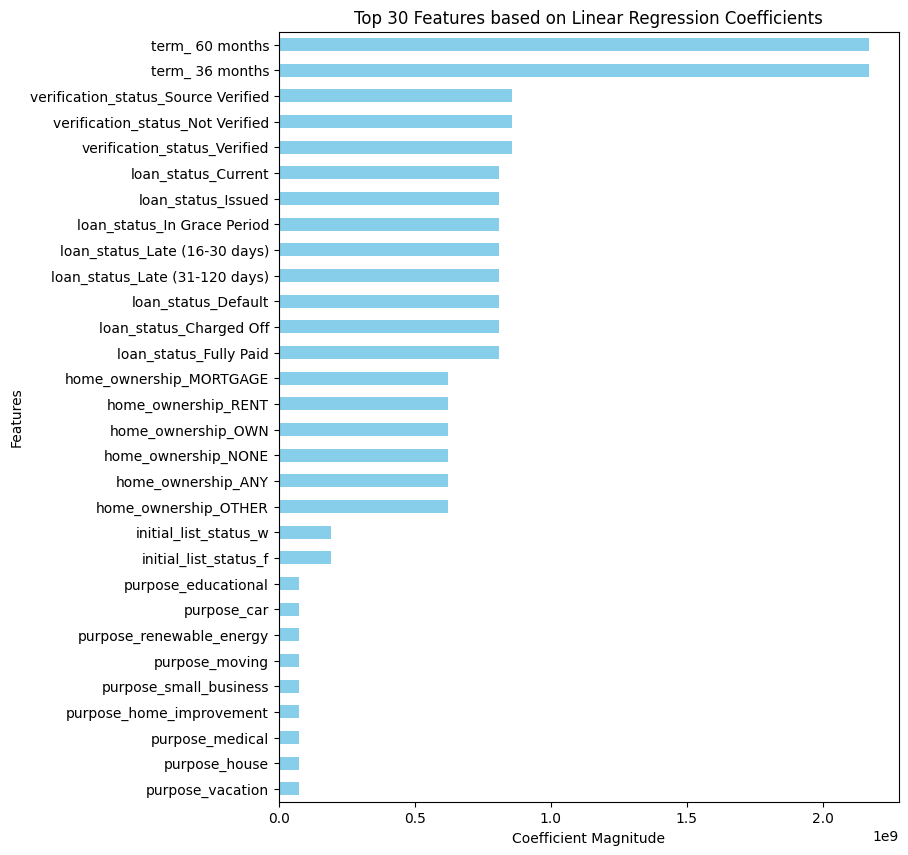

<Figure size 640x480 with 0 Axes>

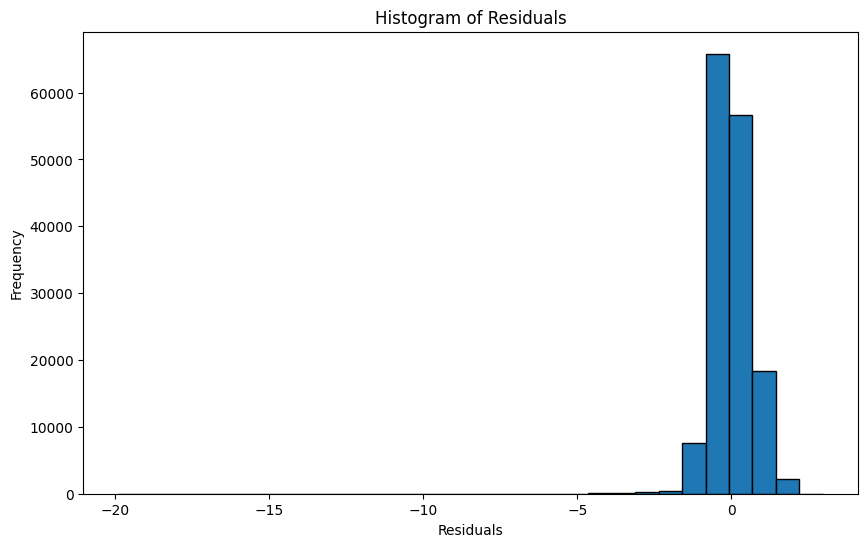

In [30]:
# Evaluate the coefficients from the Multiple Linear Regression Model
mlr_coefficients = pd.Series(mlr_model_1.coef_,index = X.columns)

top_30_mlr_features = mlr_coefficients.abs().sort_values(ascending=False).head(30)

# Plot the coefficients from the model
plt.figure(figsize = (8,10))
top_30_mlr_features.sort_values().plot(kind = 'barh',color = 'skyblue')
plt.title('Top 30 Features based on Linear Regression Coefficients')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Features')
plt.show()
plt.clf()

# Estimate the Residuals for Multiple Linear Regression
residuals = y_test - y_test_pred

# Histogram of Residuals
plt.figure(figsize = (10,6))
plt.hist(residuals,bins = 30,edgecolor = 'k')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

In [31]:
# Inspect the variables after scaling
display(pd.DataFrame(X_train,columns = numerical_cols).describe())

,loan_amnt,installment,annual_inc,dti,revol_util,out_prncp,total_rec_int,last_pymnt_amnt,collection_recovery_fee,delinq_2yrs,inq_last_6mths,pub_rec,collections_12_mths_ex_med,acc_now_delinq,open_acc
count,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05,6.058100e+05
mean,9.164888e-17,-2.028849e-16,-3.043859e-16,-1.513954e-16,1.101335e-16,-2.767881e-16,9.537864e-17,-6.751100e-17,4.363115e-18,-9.066366e-18,-3.605435e-17,6.474300e-18,2.083036e-17,-9.852196e-19,3.013423e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.676149e+00,-1.735904e+00,-1.067962e+00,-2.219927e+00,-2.368800e+00,-1.067540e+00,-8.642058e-01,-4.483564e-01,-8.124862e-02,-3.733687e-01,-6.998980e-01,-3.346165e-01,-1.093980e-01,-6.637074e-02,-2.009610e+00
25%,-7.529681e-01,-7.260911e-01,-4.335524e-01,-7.530925e-01,-7.313610e-01,-9.670941e-01,-6.356598e-01,-3.873075e-01,-8.124862e-02,-3.733687e-01,-6.998980e-01,-3.346165e-01,-1.093980e-01,-6.637074e-02,-7.032067e-01
50%,-1.375141e-01,-2.240675e-01,-1.765200e-01,-5.897637e-02,3.618835e-02,-1.858531e-01,-3.247340e-01,-3.517693e-01,-8.124862e-02,-3.733687e-01,-6.998980e-01,-3.346165e-01,-1.093980e-01,-6.637074e-02,-1.433194e-01
75%,5.726251e-01,5.640323e-01,2.097715e-01,7.089048e-01,7.738886e-01,6.179867e-01,2.423019e-01,-2.821047e-01,-8.124862e-02,-3.733687e-01,3.427267e-01,-3.346165e-01,-1.093980e-01,-6.637074e-02,4.165679e-01
max,2.347973e+00,4.079669e+00,1.400027e+02,2.615910e+00,3.568033e+01,3.058270e+00,9.893507e+00,7.015457e+00,1.058401e+02,3.344698e+01,7.641099e+00,1.425469e+02,1.425696e+02,1.731909e+02,1.460038e+01


Decision Trees (DT)

In [32]:
# Decision Tree

# Create the Decision Tree Model
dt_model_1 = DecisionTreeRegressor(random_state = 42)
dt_model_1.fit(X_train,y_train)

# Predict the values using the model on the train and test data
y_train_pred = dt_model_1.predict(X_train)
y_test_pred = dt_model_1.predict(X_test)

# Estimate the RMSE and R2 for the train and test set
dt_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
dt_train_r2 = r2_score(y_train, y_train_pred)

dt_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
dt_test_r2 = r2_score(y_test, y_test_pred)

# Print the results from the training and test data
print("Train RMSE:", dt_train_rmse)
print("Train R2:", dt_train_r2)

print("Test RMSE:", dt_test_rmse)
print("Test R2:", dt_test_r2)

Train RMSE: 1.491740602540483e-13
Train R2: 1.0
Test RMSE: 0.41680453288423247
Test R2: 0.9911102618907939


Decision Trees (Feature Importance Plots)

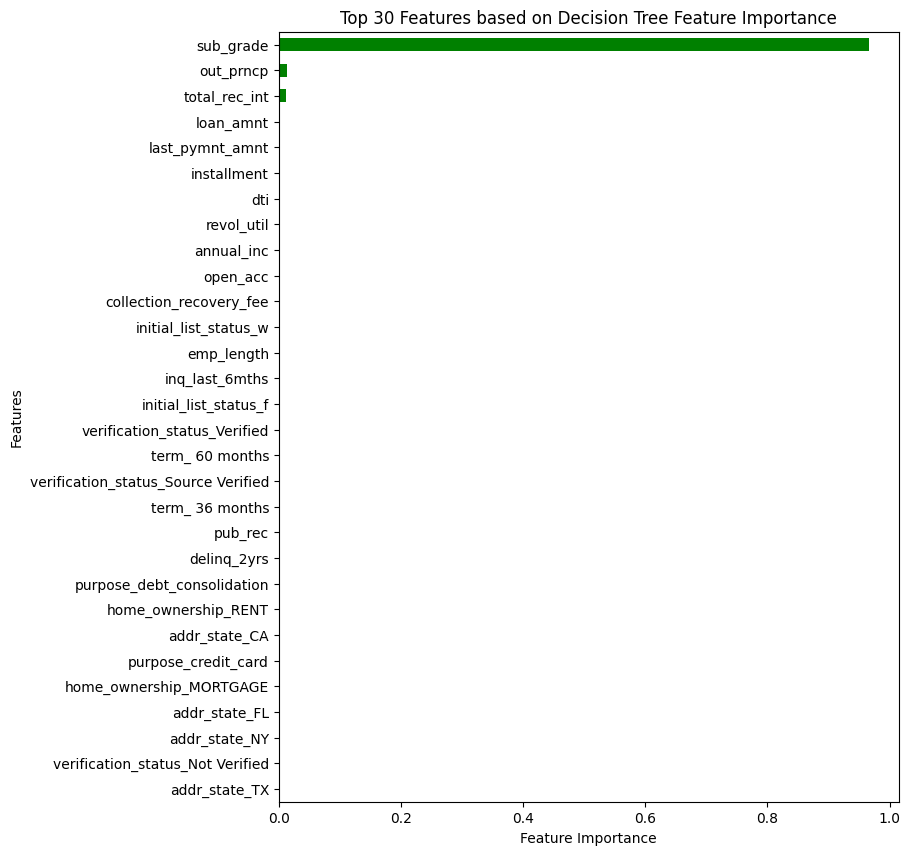

<Figure size 640x480 with 0 Axes>

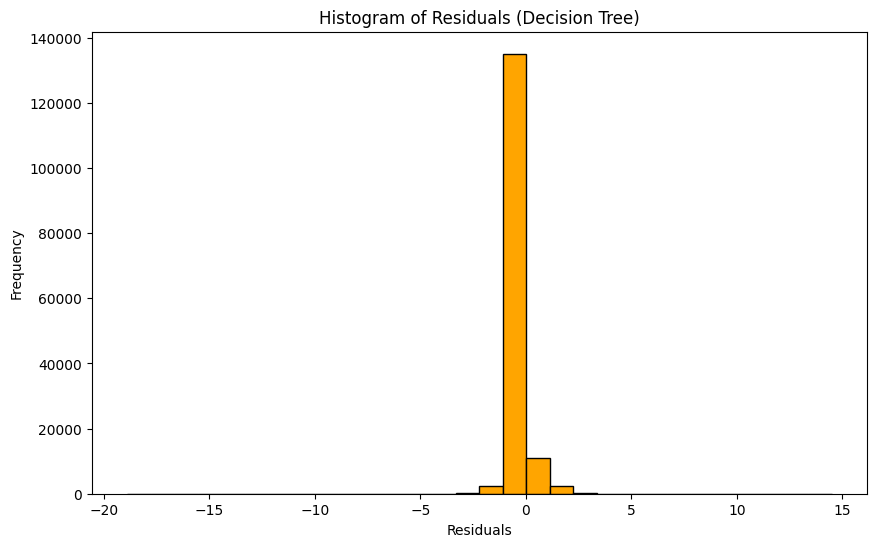

In [ ]:
# Extract Feature Importance
dt_feature_importances = pd.Series(dt_model_1.feature_importances_,index = X.columns)

# Sort the Top 30 Feature Importance
top_30_dt_features = dt_feature_importances.sort_values(ascending=False).head(30)

# Plot the Top 30 Features
plt.figure(figsize = (8,10))
top_30_dt_features.sort_values().plot(kind = 'barh',color = 'green')
plt.title('Top 30 Features based on Decision Tree Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()
plt.clf()

# Estimate the Residuals for Decision Tree
residuals = y_test - y_test_pred
plt.figure(figsize = (10,6))
plt.hist(residuals, bins=30,color = 'orange',edgecolor = 'black')
plt.title('Histogram of Residuals (Decision Tree)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

Decision Trees (With and Without Sub-Grade)

With sub_grade:
Train RMSE: 1.491740602540483e-13, Train R2: 1.0
Test RMSE: 0.41680453288423247, Test R2: 0.9911102618907939

Without sub_grade:
Train RMSE: 5.034120559616231e-15, Train R2: 1.0
Test RMSE: 1.7404151101960785, Test R2: 0.8450006808880783


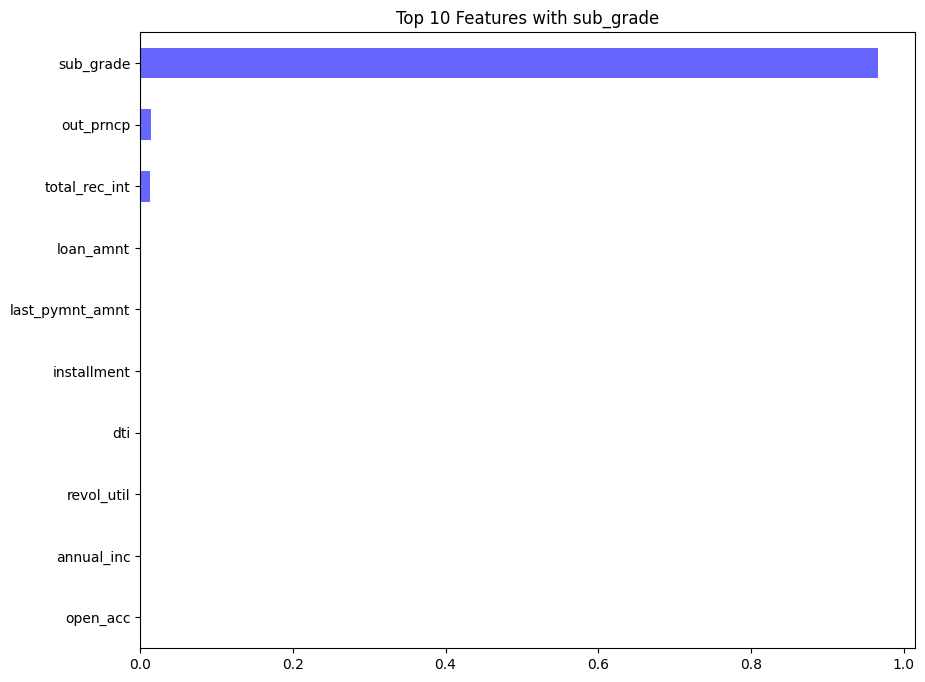

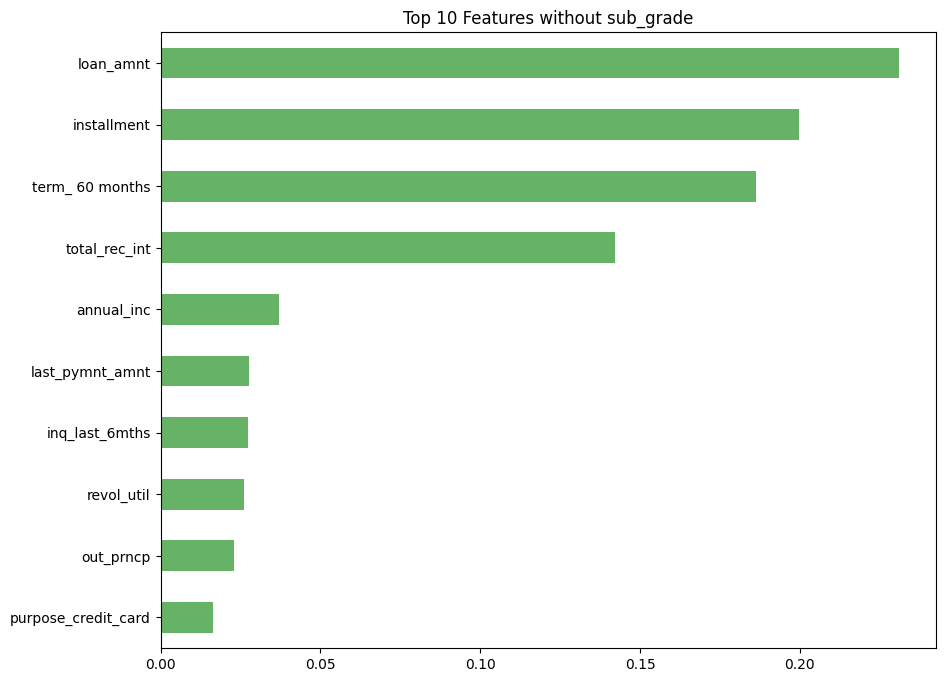

In [33]:
# 1. Create a copy of the dataset without `sub_grade`
X_train_without_sub_grade = X_train.drop(columns=['sub_grade'])
X_test_without_sub_grade = X_test.drop(columns=['sub_grade'])

# 2. Train the Decision Tree model with `sub_grade`
dt_with_sub_grade = DecisionTreeRegressor(random_state=42)
dt_with_sub_grade.fit(X_train, y_train)

# 3. Train the Decision Tree model without `sub_grade`
dt_without_sub_grade = DecisionTreeRegressor(random_state=42)
dt_without_sub_grade.fit(X_train_without_sub_grade, y_train)

# 4. Predict and calculate metrics for the model with `sub_grade`
y_train_pred_with = dt_with_sub_grade.predict(X_train)
y_test_pred_with = dt_with_sub_grade.predict(X_test)

train_rmse_with = np.sqrt(mean_squared_error(y_train, y_train_pred_with))
test_rmse_with = np.sqrt(mean_squared_error(y_test, y_test_pred_with))
train_r2_with = r2_score(y_train, y_train_pred_with)
test_r2_with = r2_score(y_test, y_test_pred_with)

# 5. Predict and calculate metrics for the model without `sub_grade`
y_train_pred_without = dt_without_sub_grade.predict(X_train_without_sub_grade)
y_test_pred_without = dt_without_sub_grade.predict(X_test_without_sub_grade)

train_rmse_without = np.sqrt(mean_squared_error(y_train, y_train_pred_without))
test_rmse_without = np.sqrt(mean_squared_error(y_test, y_test_pred_without))
train_r2_without = r2_score(y_train, y_train_pred_without)
test_r2_without = r2_score(y_test, y_test_pred_without)

# 6. Print the comparison of performance metrics
print("With sub_grade:")
print(f"Train RMSE: {train_rmse_with}, Train R2: {train_r2_with}")
print(f"Test RMSE: {test_rmse_with}, Test R2: {test_r2_with}")

print("\nWithout sub_grade:")
print(f"Train RMSE: {train_rmse_without}, Train R2: {train_r2_without}")
print(f"Test RMSE: {test_rmse_without}, Test R2: {test_r2_without}")

# 7. (Optional) Plot the Feature Importance for both models
# With sub_grade
dt_importances_with = dt_with_sub_grade.feature_importances_
dt_feature_importance_with = pd.Series(dt_importances_with, index=X_train.columns)

# Without sub_grade
dt_importances_without = dt_without_sub_grade.feature_importances_
dt_feature_importance_without = pd.Series(dt_importances_without, index=X_train_without_sub_grade.columns)

# Plot Feature Importance for the model with sub_grade
plt.figure(figsize=(10, 8))
dt_feature_importance_with.sort_values().tail(10).plot(kind='barh', color='blue', alpha=0.6)
plt.title('Top 10 Features with sub_grade')

# Plot Feature Importance for the model without sub_grade
plt.figure(figsize=(10, 8))
dt_feature_importance_without.sort_values().tail(10).plot(kind='barh', color='green', alpha=0.6)
plt.title('Top 10 Features without sub_grade')

plt.show()

Create the Decision Tree Model with Regularization (Pruning)

With sub_grade:
Train RMSE: 0.6148449674405709, Train R2: 0.9805723848467197
Test RMSE: 0.6178269264903674, Test R2: 0.980467503094884

Without sub_grade:
Train RMSE: 3.2308418325643693, Train R2: 0.46356186814047606
Test RMSE: 3.2351932641748635, Test R2: 0.4644197428370528


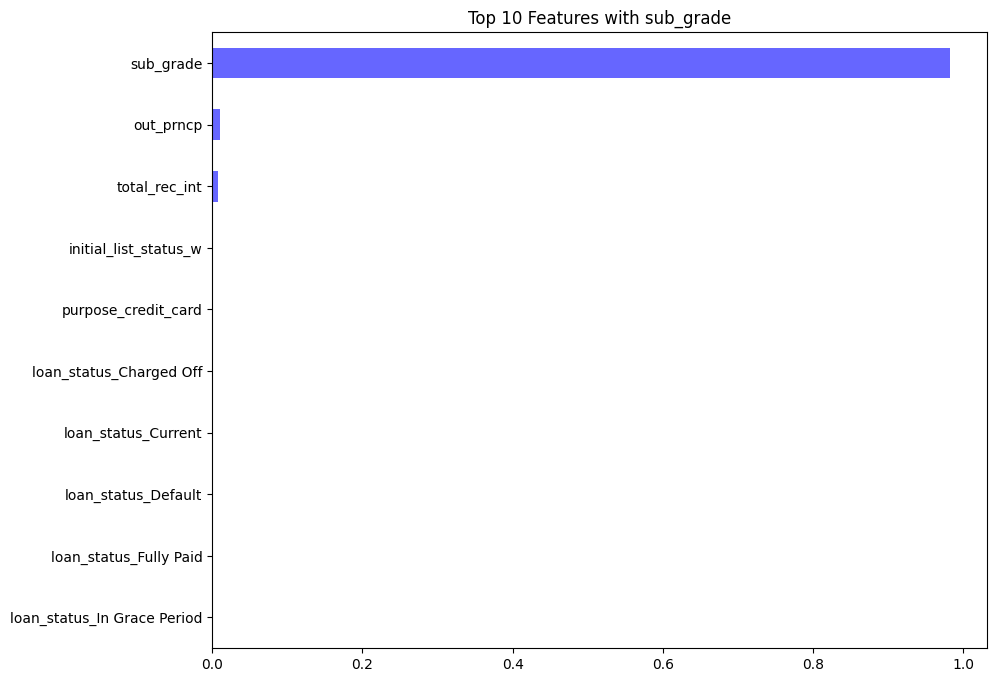

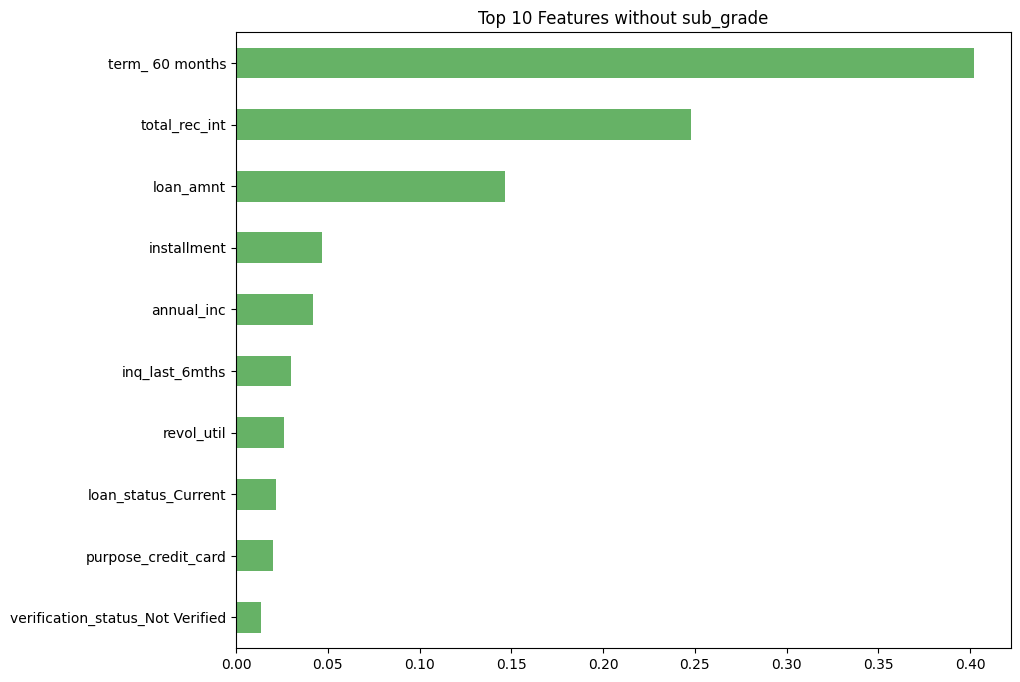

In [34]:
# Create the Decision Tree Model with Regularization (Pruning)
# Here, max_depth, min_samples_split, and min_samples_leaf are regularization parameters
dt_model_with_sub_grade = DecisionTreeRegressor(random_state=42, max_depth=6, min_samples_split=20, min_samples_leaf=10)
dt_model_without_sub_grade = DecisionTreeRegressor(random_state=42, max_depth=6, min_samples_split=20, min_samples_leaf=10)

# 1. Train the model with sub_grade
dt_model_with_sub_grade.fit(X_train, y_train)

# 2. Train the model without sub_grade
X_train_without_sub_grade = X_train.drop(columns=['sub_grade'])
X_test_without_sub_grade = X_test.drop(columns=['sub_grade'])
dt_model_without_sub_grade.fit(X_train_without_sub_grade, y_train)

# 3. Predict and calculate metrics for the model with sub_grade
y_train_pred_with = dt_model_with_sub_grade.predict(X_train)
y_test_pred_with = dt_model_with_sub_grade.predict(X_test)

train_rmse_with = np.sqrt(mean_squared_error(y_train, y_train_pred_with))
test_rmse_with = np.sqrt(mean_squared_error(y_test, y_test_pred_with))
train_r2_with = r2_score(y_train, y_train_pred_with)
test_r2_with = r2_score(y_test, y_test_pred_with)

# 4. Predict and calculate metrics for the model without sub_grade
y_train_pred_without = dt_model_without_sub_grade.predict(X_train_without_sub_grade)
y_test_pred_without = dt_model_without_sub_grade.predict(X_test_without_sub_grade)

train_rmse_without = np.sqrt(mean_squared_error(y_train, y_train_pred_without))
test_rmse_without = np.sqrt(mean_squared_error(y_test, y_test_pred_without))
train_r2_without = r2_score(y_train, y_train_pred_without)
test_r2_without = r2_score(y_test, y_test_pred_without)

# 5. Print the comparison of performance metrics
print("With sub_grade:")
print(f"Train RMSE: {train_rmse_with}, Train R2: {train_r2_with}")
print(f"Test RMSE: {test_rmse_with}, Test R2: {test_r2_with}")

print("\nWithout sub_grade:")
print(f"Train RMSE: {train_rmse_without}, Train R2: {train_r2_without}")
print(f"Test RMSE: {test_rmse_without}, Test R2: {test_r2_without}")

# 6. Plot Feature Importance for both models
# With sub_grade
dt_importances_with = dt_model_with_sub_grade.feature_importances_
dt_feature_importance_with = pd.Series(dt_importances_with, index=X_train.columns)

# Without sub_grade
dt_importances_without = dt_model_without_sub_grade.feature_importances_
dt_feature_importance_without = pd.Series(dt_importances_without, index=X_train_without_sub_grade.columns)

# Plot Feature Importance for both models
plt.figure(figsize=(10, 8))
dt_feature_importance_with.sort_values().tail(10).plot(kind='barh', color='blue', alpha=0.6)
plt.title('Top 10 Features with sub_grade')

plt.figure(figsize=(10, 8))
dt_feature_importance_without.sort_values().tail(10).plot(kind='barh', color='green', alpha=0.6)
plt.title('Top 10 Features without sub_grade')

plt.show()

Random Forest (RF)

In [35]:
# Random Forest

# Create the Random Forest Model
rf_model_1 = RandomForestRegressor(n_estimators=100, max_depth=10, max_features='sqrt', n_jobs=-1, random_state=42)
rf_model_1.fit(X_train, y_train)

# Predict the values using the model on the train and test data
y_train_pred = rf_model_1.predict(X_train)
y_test_pred = rf_model_1.predict(X_test)

# Estimate the RMSE and R2 for the train and test set
rf_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
rf_train_r2 = r2_score(y_train, y_train_pred)

rf_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
rf_test_r2 = r2_score(y_test, y_test_pred)

# Print the results from the training and test data
print("Train RMSE:", rf_train_rmse)
print("Train R2:", rf_train_r2)

print("Test RMSE:", rf_test_rmse)
print("Test R2:", rf_test_r2)

Train RMSE: 1.7847916374395023
Train R2: 0.8362944921783961
Test RMSE: 1.801482712818555
Test R2: 0.833932633767049


Random Forest (Feature Importance Plots)

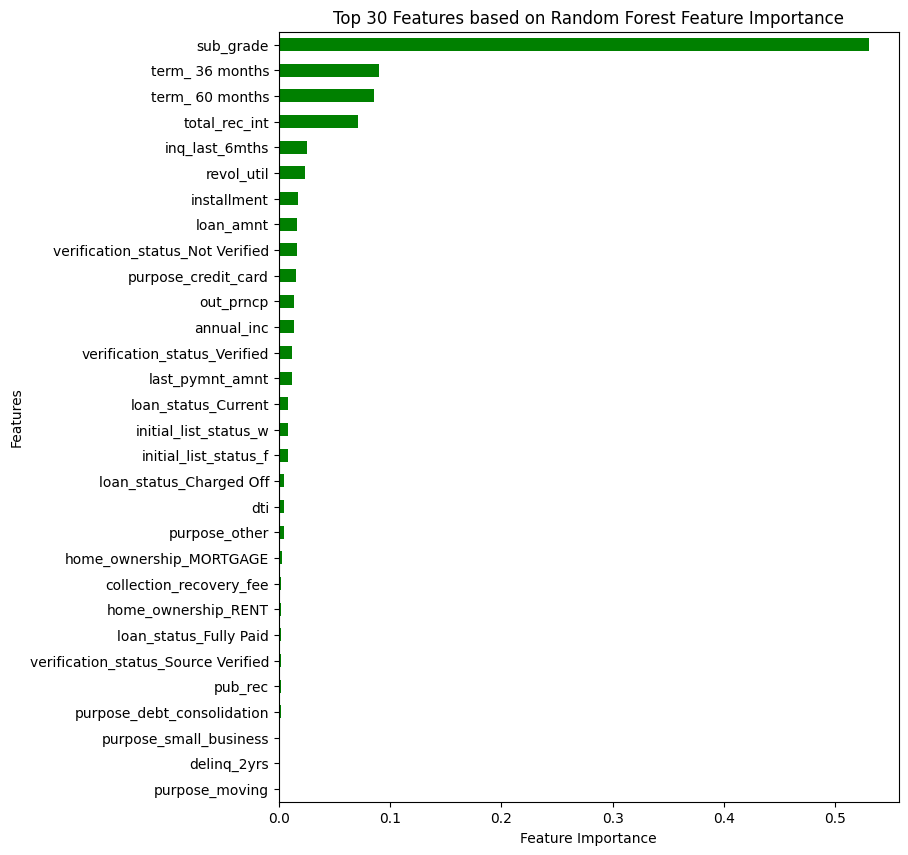

<Figure size 640x480 with 0 Axes>

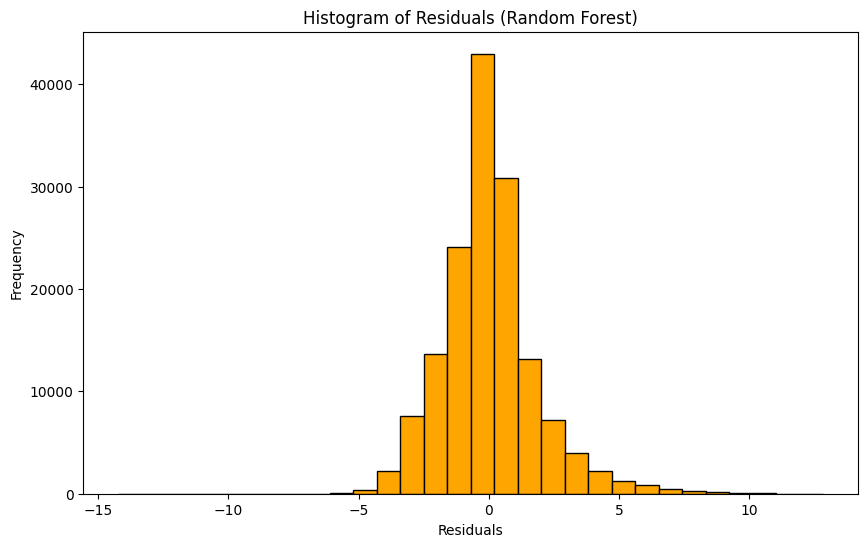

In [36]:
# Extract Feature Importance
rf_feature_importances = pd.Series(rf_model_1.feature_importances_, index=X.columns)

# Sort the Top 30 Feature Importance
top_30_rf_features = rf_feature_importances.sort_values(ascending=False).head(30)

# Plot the Top 30 Features
plt.figure(figsize=(8, 10))
top_30_rf_features.sort_values().plot(kind='barh', color='green')
plt.title('Top 30 Features based on Random Forest Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()
plt.clf()

# Estimate the Residuals for Random Forest
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='orange', edgecolor='black')
plt.title('Histogram of Residuals (Random Forest)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

Random Forest (With and Without Sub-Grade)

With sub_grade:
Train RMSE: 1.7847916374395023, Train R2: 0.8362944921783961
Test RMSE: 1.801482712818555, Test R2: 0.833932633767049

Without sub_grade:
Train RMSE: 3.0575890258361333, Train R2: 0.5195519130342001
Test RMSE: 3.0772946271211135, Test R2: 0.5154236021827493


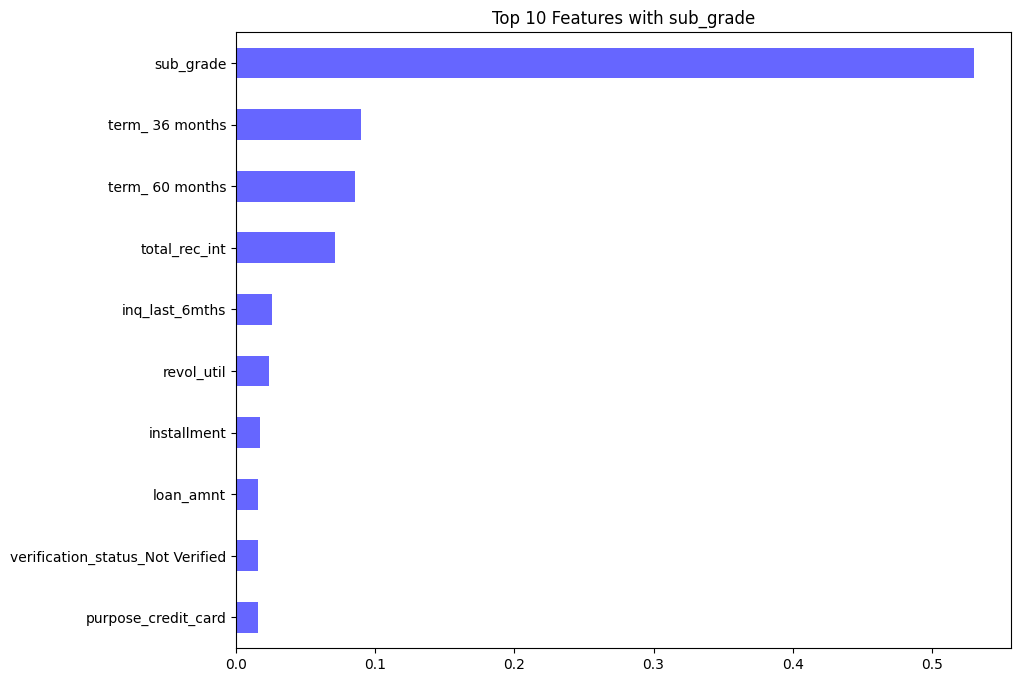

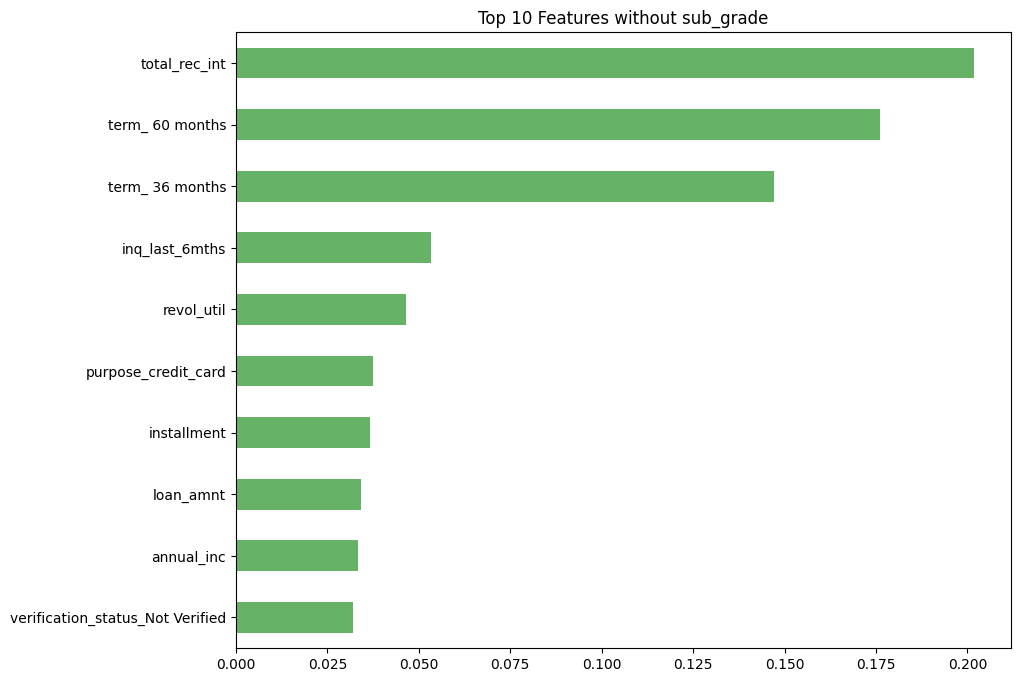

In [37]:
# 1. Create a copy of the dataset without `sub_grade`
X_train_without_sub_grade = X_train.drop(columns=['sub_grade'])
X_test_without_sub_grade = X_test.drop(columns=['sub_grade'])

# 2. Train the Random Forest model with `sub_grade`
rf_with_sub_grade = RandomForestRegressor(n_estimators=100, max_depth=10, max_features='sqrt', n_jobs=-1, random_state=42)
rf_with_sub_grade.fit(X_train, y_train)

# 3. Train the Random Forest model without `sub_grade`
rf_without_sub_grade = RandomForestRegressor(n_estimators=100, max_depth=10, max_features='sqrt', n_jobs=-1, random_state=42)
rf_without_sub_grade.fit(X_train_without_sub_grade, y_train)

# 4. Predict and calculate metrics for the model with `sub_grade`
y_train_pred_with = rf_with_sub_grade.predict(X_train)
y_test_pred_with = rf_with_sub_grade.predict(X_test)

train_rmse_with = np.sqrt(mean_squared_error(y_train, y_train_pred_with))
test_rmse_with = np.sqrt(mean_squared_error(y_test, y_test_pred_with))
train_r2_with = r2_score(y_train, y_train_pred_with)
test_r2_with = r2_score(y_test, y_test_pred_with)

# 5. Predict and calculate metrics for the model without `sub_grade`
y_train_pred_without = rf_without_sub_grade.predict(X_train_without_sub_grade)
y_test_pred_without = rf_without_sub_grade.predict(X_test_without_sub_grade)

train_rmse_without = np.sqrt(mean_squared_error(y_train, y_train_pred_without))
test_rmse_without = np.sqrt(mean_squared_error(y_test, y_test_pred_without))
train_r2_without = r2_score(y_train, y_train_pred_without)
test_r2_without = r2_score(y_test, y_test_pred_without)

# 6. Print the comparison of performance metrics
print("With sub_grade:")
print(f"Train RMSE: {train_rmse_with}, Train R2: {train_r2_with}")
print(f"Test RMSE: {test_rmse_with}, Test R2: {test_r2_with}")

print("\nWithout sub_grade:")
print(f"Train RMSE: {train_rmse_without}, Train R2: {train_r2_without}")
print(f"Test RMSE: {test_rmse_without}, Test R2: {test_r2_without}")

# 7. (Optional) Plot the Feature Importance for both models
# With sub_grade
rf_importances_with = rf_with_sub_grade.feature_importances_
rf_feature_importance_with = pd.Series(rf_importances_with, index=X_train.columns)

# Without sub_grade
rf_importances_without = rf_without_sub_grade.feature_importances_
rf_feature_importance_without = pd.Series(rf_importances_without, index=X_train_without_sub_grade.columns)

# Plot Feature Importance for both models
plt.figure(figsize=(10, 8))
rf_feature_importance_with.sort_values().tail(10).plot(kind='barh', color='blue', alpha=0.6)
plt.title('Top 10 Features with sub_grade')

plt.figure(figsize=(10, 8))
rf_feature_importance_without.sort_values().tail(10).plot(kind='barh', color='green', alpha=0.6)
plt.title('Top 10 Features without sub_grade')

plt.show()

In [38]:
!pip install tensorflow

Neural Networks (NN) --> 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
18932/18932 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 1.6087 - val_loss: 0.1553
Epoch 2/50
18932/18932 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - loss: 0.1580 - val_loss: 0.1165
Epoch 3/50
18932/18932 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - loss: 0.1210 - val_loss: 0.0963
Epoch 4/50
18932/18932 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 0.1013 - val_loss: 0.0835
Epoch 5/50
18932/18932 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 0.0861 - val_loss: 0.0690
Epoch 6/50
18932/18932 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 0.0755 - val_loss: 0.0615
Epoch 7/50
18932/18932 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - loss: 0.0675 - val_loss: 0.0554
Epoch 8/50
18932/18932 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 0.0617 - val_loss: 0.0504
Epoch 9/50
18932/18932 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 0.0577 - val_loss: 0.0489
Epoch 10/50
18932/18932 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 0.0537 - val_loss: 0.0461
Epoch 11/50
18932/18932 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - loss: 0.0520 - val_loss: 0.03

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           6,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,309 (102.77 KB)

 Trainable params: 8,769 (34.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,540 (68.52 KB)

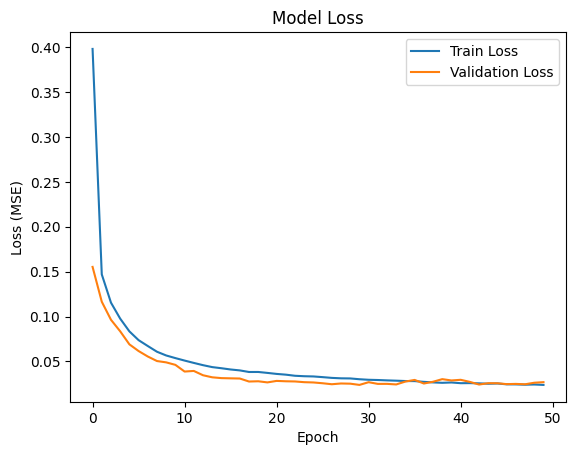

In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

tf.random.set_seed(42)
# Define the neural network model
model = Sequential()

# Input layer and first hidden layer with 64 neurons and ReLU activation
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))

# Second hidden layer with 32 neurons and ReLU activation
model.add(Dense(32, activation='relu'))

# Output layer (single neuron since this is a regression task)
model.add(Dense(1))

# Compile the model (using Mean Squared Error loss and Adam optimizer)
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1)

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate RMSE and R^2 for train and test sets
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the results
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Train R^2: {train_r2}")
print(f"Test R^2: {test_r2}")

model.summary()

# Plot the loss during training
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

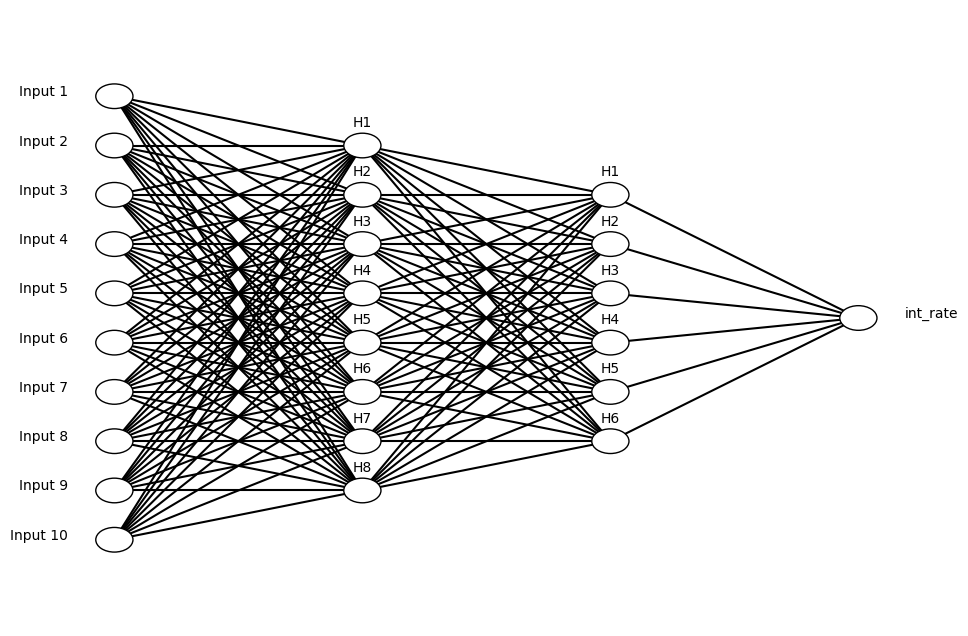

In [70]:
import matplotlib.pyplot as plt

def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    '''
    Draw a neural network cartoon using Matplotlib and label the input, hidden, and output layers.
    '''
    v_spacing = (top - bottom) / float(max(layer_sizes))  # Vertical spacing
    h_spacing = (right - left) / float(len(layer_sizes) - 1)  # Horizontal spacing

    # Draw the nodes (neurons)
    for i, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing * (layer_size - 1) / 2. + (top + bottom) / 2.
        for j in range(layer_size):
            circle = plt.Circle((left + i * h_spacing, layer_top - j * v_spacing), v_spacing / 4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)

            # Add labels for input layer, hidden layers, and output layer neurons
            if i == 0:  # Input layer
                ax.text(left + i * h_spacing - 0.05, layer_top - j * v_spacing, f'Input {j+1}', fontsize=10, ha='right')
            elif i == len(layer_sizes) - 1:  # Output layer
                ax.text(left + i * h_spacing + 0.05, layer_top - j * v_spacing, 'int_rate', fontsize=10, ha='left')
            else:  # Hidden layers
                ax.text(left + i * h_spacing, layer_top - j * v_spacing + 0.03, f'H{j+1}', fontsize=10, ha='center')

    # Draw the edges (connections)
    for i, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing * (layer_size_a - 1) / 2. + (top + bottom) / 2.
        layer_top_b = v_spacing * (layer_size_b - 1) / 2. + (top + bottom) / 2.
        for j in range(layer_size_a):
            for k in range(layer_size_b):
                line = plt.Line2D([left + i * h_spacing, left + (i + 1) * h_spacing],
                                  [layer_top_a - j * v_spacing, layer_top_b - k * v_spacing], c='k')
                ax.add_artist(line)

# Customize the structure of your network: [input layer (showing only first 10 neurons), hidden1, hidden2, output]
layer_sizes = [10, 8, 6, 1]  # Input: 10, Hidden1: 8, Hidden2: 6, Output: 1

# Create a figure to draw the network
fig = plt.figure(figsize=(12, 8))  # Adjusted figure size to fit 10 input neurons
ax = fig.gca()
ax.axis('off')  # Remove axis

# Draw the neural network with labels for input, hidden, and output layers
draw_neural_net(ax, .1, .9, .1, .9, layer_sizes)

# Show the plot
plt.show()

In [40]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 9.8 MB/s eta 0:00:00


In [41]:
print(X_train.dtypes)
print(X_test.dtypes)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

loan_amnt                float64
installment              float64
annual_inc               float64
dti                      float64
revol_util               float64
                          ...   
addr_state_WI               bool
addr_state_WV               bool
addr_state_WY               bool
initial_list_status_f       bool
initial_list_status_w       bool
Length: 103, dtype: object
loan_amnt                float64
installment              float64
annual_inc               float64
dti                      float64
revol_util               float64
                          ...   
addr_state_WI               bool
addr_state_WV               bool
addr_state_WY               bool
initial_list_status_f       bool
initial_list_status_w       bool
Length: 103, dtype: object
Shape of X_train: (605810, 103)
Shape of X_test: (151453, 103)


In [43]:
!pip install shap

Neural Networks (NN) --> SHAP Analysis --> 1

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


Shape of SHAP values: (100, 103)
Shape of X_test_sample_df: (100, 103)


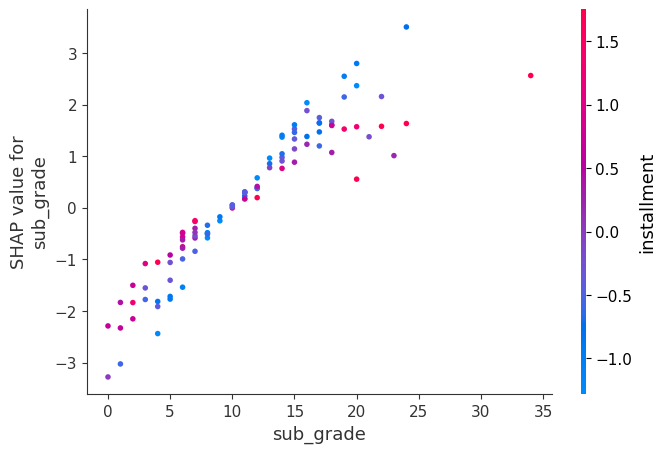

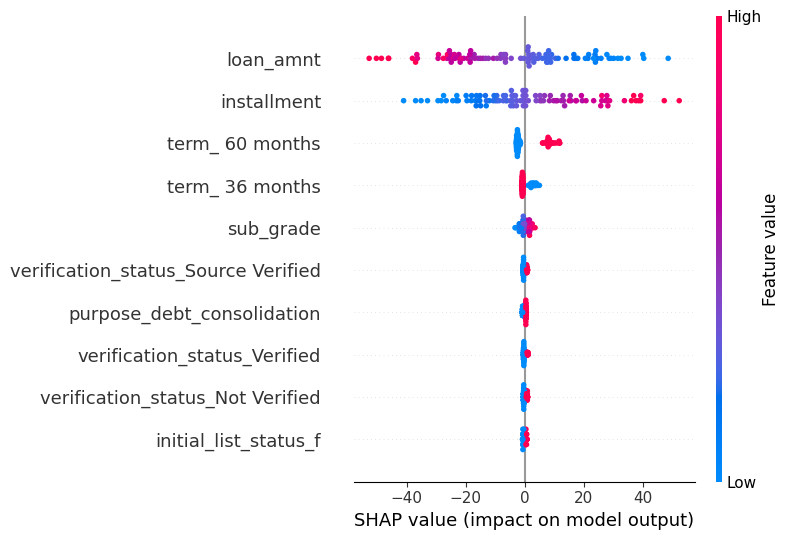

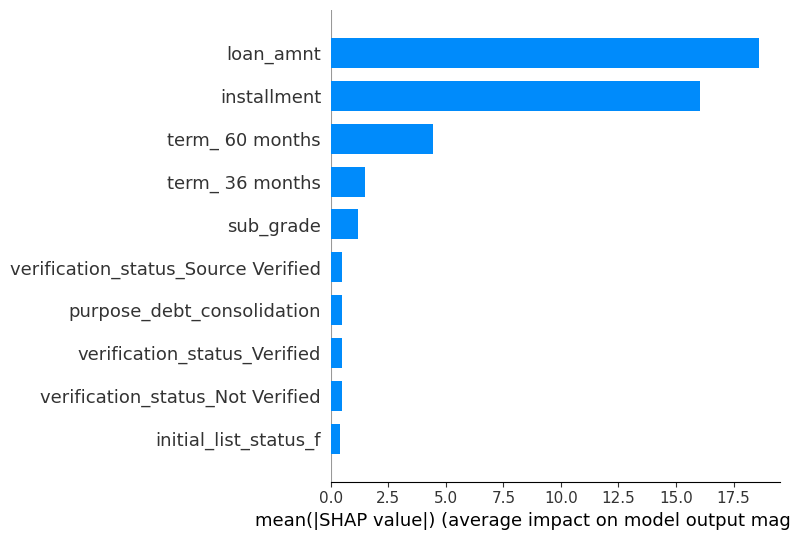

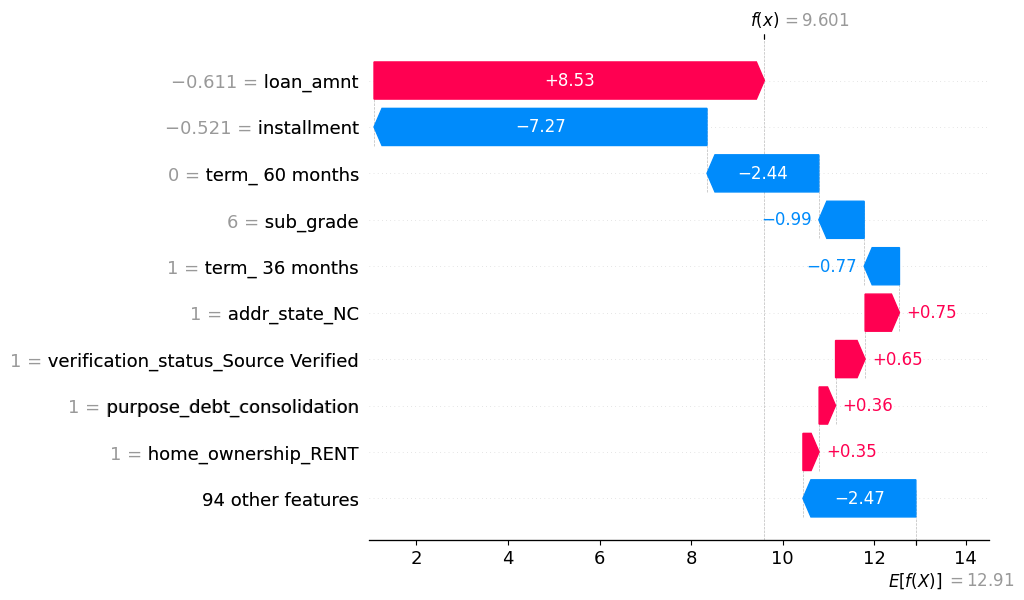

In [49]:
import shap

# Convert boolean columns to float for SHAP compatibility
X_train = X_train.astype(float)
X_test = X_test.astype(float)

# Set the background sample size to 100
X_train_background = X_train.sample(100, random_state=42)  # Randomly select 100 samples for background

# Use only 100 samples for the test data as well
X_test_sample = np.array(X_test[:100], dtype=np.float32)

# Create the DeepExplainer for the neural network model with the background sample
explainer = shap.DeepExplainer(model, X_train_background)

# Compute SHAP values for the test set (sample size of 100)
shap_values = explainer.shap_values(X_test_sample)

# Handle SHAP values for single-output models and squeeze the extra dimension
if isinstance(shap_values, list):
    shap_values_corrected = shap_values[0].squeeze()  # Squeeze to remove extra dimension
else:
    shap_values_corrected = shap_values.squeeze()

# Convert X_test_sample to DataFrame for plotting
X_test_sample_df = pd.DataFrame(X_test_sample, columns=X_test.columns)

# Check the shapes of SHAP values and test data to confirm consistency
print("Shape of SHAP values:", shap_values_corrected.shape)
print("Shape of X_test_sample_df:", X_test_sample_df.shape)

# Plot the dependence plot for 'sub_grade'
if 'sub_grade' in X_test_sample_df.columns:
    shap.dependence_plot('sub_grade', shap_values_corrected, X_test_sample_df)
else:
    print("The feature 'sub_grade' is not in the dataset.")

# SHAP Summary Plot showing the top 10 important features
shap.summary_plot(shap_values_corrected, X_test_sample, feature_names=X_test.columns, max_display=10)

# SHAP Summary Plot with bar chart for the top 10 features
shap.summary_plot(shap_values_corrected, X_test_sample, feature_names=X_test.columns, max_display=10, plot_type='bar')

# Waterfall Plot for a specific instance (first test instance in this case)
instance_index = 0
instance_shap_values = shap_values_corrected[instance_index]

# Convert TensorFlow scalar expected_value to a numpy value
expected_value = explainer.expected_value[0].numpy() if isinstance(explainer.expected_value[0], tf.Tensor) else explainer.expected_value[0]

# Plot the waterfall plot for the first test instance
shap.waterfall_plot(
    shap.Explanation(
        values=instance_shap_values,
        base_values=expected_value,  # Convert TensorFlow scalar to numpy value
        data=X_test_sample_df.iloc[instance_index],
        feature_names=X_test.columns
    )
)

Neural Networks (NN) --> 2 --> Dropped Installment Variable

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
18932/18932 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 1.8998 - val_loss: 0.1637
Epoch 2/50
18932/18932 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 0.1646 - val_loss: 0.1317
Epoch 3/50
18932/18932 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 0.1379 - val_loss: 0.1291
Epoch 4/50
18932/18932 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 0.1305 - val_loss: 0.1228
Epoch 5/50
18932/18932 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 0.1262 - val_loss: 0.1215
Epoch 6/50
18932/18932 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.1236 - val_loss: 0.1183
Epoch 7/50
18932/18932 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.1216 - val_loss: 0.1191
Epoch 8/50
18932/18932 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - loss: 0.1206 - val_loss: 0.1174
Epoch 9/50
18932/18932 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step - loss: 0.1187 - val_loss: 0.1145
Epoch 10/50
18932/18932 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.1180 - val_loss: 0.1138
Epoch 11/50
18932/18932 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step - loss: 0.1166 - val_loss: 0.11

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 64)                  │           6,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,117 (102.02 KB)

 Trainable params: 8,705 (34.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,412 (68.02 KB)

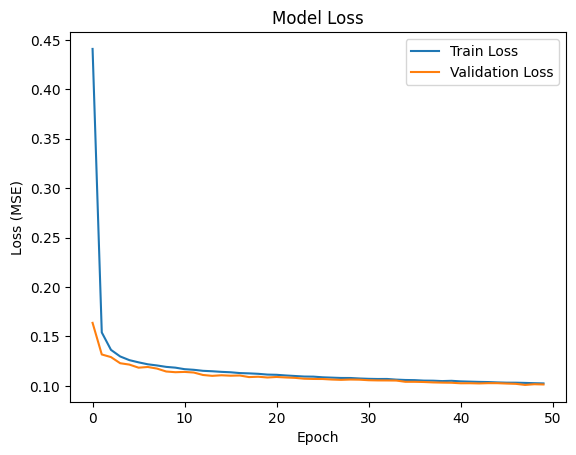

In [50]:
# Set a random seed for reproducibility
tf.random.set_seed(42)

# Make a copy of X_train and X_test without 'installment'
X_train_modified = X_train.drop(columns=['installment'])
X_test_modified = X_test.drop(columns=['installment'])

# Define the neural network model
model = Sequential()

# Input layer and first hidden layer with 64 neurons and ReLU activation
model.add(Dense(64, input_dim=X_train_modified.shape[1], activation='relu'))

# Second hidden layer with 32 neurons and ReLU activation
model.add(Dense(32, activation='relu'))

# Output layer (single neuron since this is a regression task)
model.add(Dense(1))

# Compile the model (using Mean Squared Error loss and Adam optimizer)
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train_modified, y_train, validation_data=(X_test_modified, y_test), epochs=50, batch_size=32, verbose=1)

# Make predictions
y_train_pred = model.predict(X_train_modified)
y_test_pred = model.predict(X_test_modified)

# Calculate RMSE and R^2 for train and test sets
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the results
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Train R^2: {train_r2}")
print(f"Test R^2: {test_r2}")

# Display the model summary
model.summary()

# Plot the loss during training
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

Neural Networks (NN) --> Shap Analysis --> 2

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


Shape of SHAP values: (100, 102)
Shape of X_test_sample_df: (100, 102)


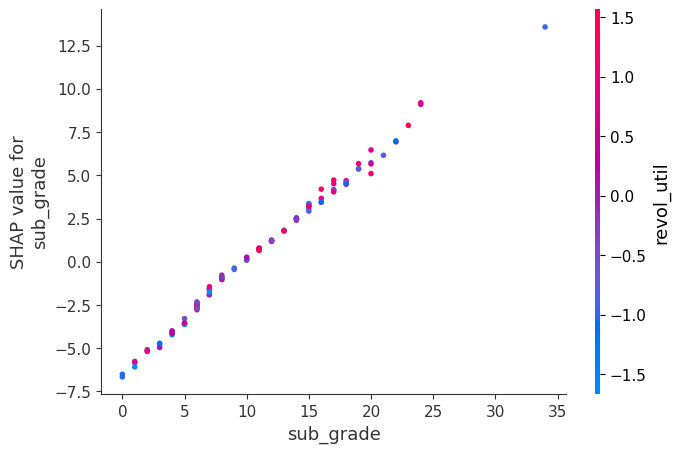

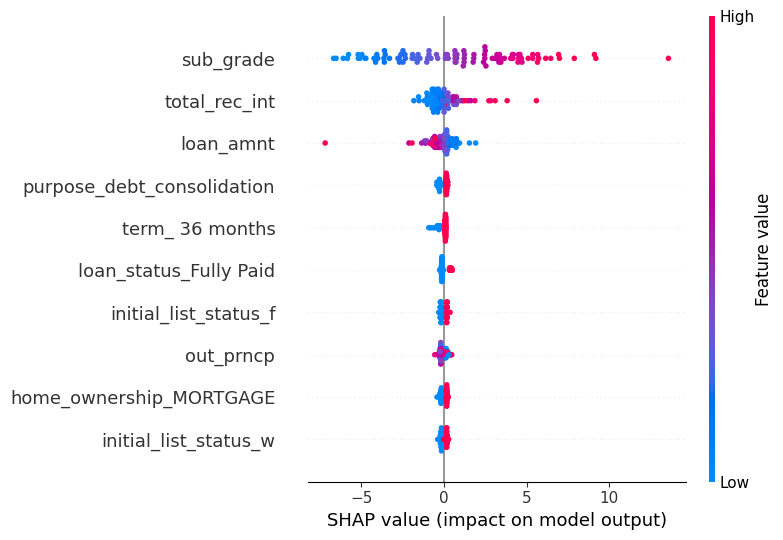

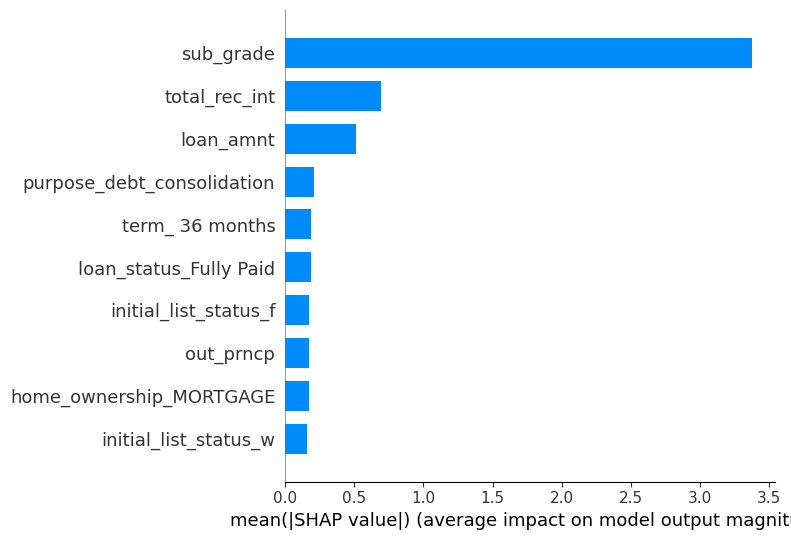

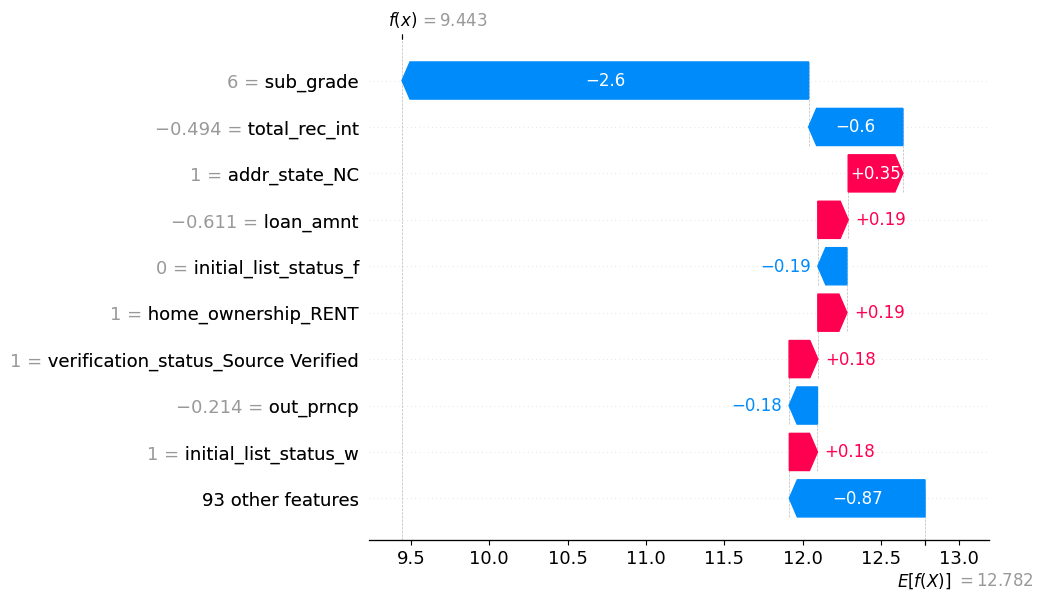

In [51]:
# SHAP Analysis

# Convert boolean columns to float for SHAP compatibility
X_train_modified = X_train_modified.astype(float)
X_test_modified = X_test_modified.astype(float)

# Set the background sample size to 100 (use the modified X_train without 'installment')
X_train_background = X_train_modified.sample(100, random_state=42)  # Randomly select 100 samples for background

# Use only 100 samples for the test data as well
X_test_sample = np.array(X_test_modified[:100], dtype=np.float32)

# Create the DeepExplainer for the neural network model with the background sample
explainer = shap.DeepExplainer(model, X_train_background)

# Compute SHAP values for the test set (sample size of 100)
shap_values = explainer.shap_values(X_test_sample)

# Handle SHAP values for single-output models and squeeze the extra dimension
if isinstance(shap_values, list):
    shap_values_corrected = shap_values[0].squeeze()  # Squeeze to remove extra dimension
else:
    shap_values_corrected = shap_values.squeeze()

# Convert X_test_sample to DataFrame for plotting (use the columns from X_test_modified)
X_test_sample_df = pd.DataFrame(X_test_sample, columns=X_test_modified.columns)

# Check the shapes of SHAP values and test data to confirm consistency
print("Shape of SHAP values:", shap_values_corrected.shape)
print("Shape of X_test_sample_df:", X_test_sample_df.shape)

# Plot the dependence plot for 'sub_grade'
if 'sub_grade' in X_test_sample_df.columns:
    shap.dependence_plot('sub_grade', shap_values_corrected, X_test_sample_df)
else:
    print("The feature 'sub_grade' is not in the dataset.")

# SHAP Summary Plot showing the top 10 important features
shap.summary_plot(shap_values_corrected, X_test_sample, feature_names=X_test_modified.columns, max_display=10)

# SHAP Summary Plot with bar chart for the top 10 features
shap.summary_plot(shap_values_corrected, X_test_sample, feature_names=X_test_modified.columns, max_display=10, plot_type='bar')

# Waterfall Plot for a specific instance (first test instance in this case)
instance_index = 0
instance_shap_values = shap_values_corrected[instance_index]

# Convert TensorFlow scalar expected_value to a numpy value
expected_value = explainer.expected_value[0].numpy() if isinstance(explainer.expected_value[0], tf.Tensor) else explainer.expected_value[0]

# Plot the waterfall plot for the first test instance
shap.waterfall_plot(
    shap.Explanation(
        values=instance_shap_values,
        base_values=expected_value,  # Convert TensorFlow scalar to numpy value
        data=X_test_sample_df.iloc[instance_index],
        feature_names=X_test_sample_df.columns
    )
)

Final XG Boost Model With Cross Validation (With and Without Subgrade) -- Non Engineered Data

In [54]:
from sklearn.model_selection import cross_val_score, KFold

# 1. Create a copy of the dataset without `sub_grade`
X_train_without_sub_grade = X_train.drop(columns=['sub_grade'])
X_test_without_sub_grade = X_test.drop(columns=['sub_grade'])

# 2. Define the 5-fold cross-validation scheme
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 3. Cross-validation for the model with `sub_grade`
xgb_with_sub_grade_final_model = xgb.XGBRegressor(random_state=42)

# Perform cross-validation for RMSE and R²
cv_rmse_with = np.sqrt(-cross_val_score(xgb_with_sub_grade_final_model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf))
cv_r2_with = cross_val_score(xgb_with_sub_grade_final_model, X_train, y_train, scoring="r2", cv=kf)

# Print the individual cross-validation scores for RMSE and R²
print("\nCross-Validation Scores with sub_grade:")
print("RMSE Scores:", cv_rmse_with)
print("R² Scores:", cv_r2_with)

# Print the average cross-validation RMSE and R²
print(f"\nCV Results with sub_grade - RMSE: {cv_rmse_with.mean():.4f}, R²: {cv_r2_with.mean():.4f}")

# Fit the model after cross-validation
xgb_with_sub_grade_final_model.fit(X_train, y_train)

# Training and Testing Scores with `sub_grade`
y_train_pred_with = xgb_with_sub_grade_final_model.predict(X_train)
y_test_pred_with = xgb_with_sub_grade_final_model.predict(X_test)

train_rmse_with = np.sqrt(mean_squared_error(y_train, y_train_pred_with))
test_rmse_with = np.sqrt(mean_squared_error(y_test, y_test_pred_with))
train_r2_with = r2_score(y_train, y_train_pred_with)
test_r2_with = r2_score(y_test, y_test_pred_with)

print("\nTraining and Testing Scores with sub_grade:")
print(f"Train RMSE: {train_rmse_with:.4f}, Train R²: {train_r2_with:.4f}")
print(f"Test RMSE: {test_rmse_with:.4f}, Test R²: {test_r2_with:.4f}")

# 4. Cross-validation for the model without `sub_grade`
xgb_without_sub_grade_final_model = xgb.XGBRegressor(random_state=42)

# Perform cross-validation for RMSE and R²
cv_rmse_without = np.sqrt(-cross_val_score(xgb_without_sub_grade_final_model, X_train_without_sub_grade, y_train, scoring="neg_mean_squared_error", cv=kf))
cv_r2_without = cross_val_score(xgb_without_sub_grade_final_model, X_train_without_sub_grade, y_train, scoring="r2", cv=kf)

# Print the individual cross-validation scores for RMSE and R²
print("\nCross-Validation Scores without sub_grade:")
print("RMSE Scores:", cv_rmse_without)
print("R² Scores:", cv_r2_without)

# Print the average cross-validation RMSE and R²
print(f"\nCV Results without sub_grade - RMSE: {cv_rmse_without.mean():.4f}, R²: {cv_r2_without.mean():.4f}")

# Fit the model after cross-validation
xgb_without_sub_grade_final_model.fit(X_train_without_sub_grade, y_train)

# Training and Testing Scores without `sub_grade`
y_train_pred_without = xgb_without_sub_grade_final_model.predict(X_train_without_sub_grade)
y_test_pred_without = xgb_without_sub_grade_final_model.predict(X_test_without_sub_grade)

train_rmse_without = np.sqrt(mean_squared_error(y_train, y_train_pred_without))
test_rmse_without = np.sqrt(mean_squared_error(y_test, y_test_pred_without))
train_r2_without = r2_score(y_train, y_train_pred_without)
test_r2_without = r2_score(y_test, y_test_pred_without)

print("\nTraining and Testing Scores without sub_grade:")
print(f"Train RMSE: {train_rmse_without:.4f}, Train R²: {train_r2_without:.4f}")
print(f"Test RMSE: {test_rmse_without:.4f}, Test R²: {test_r2_without:.4f}")


Cross-Validation Scores with sub_grade:
RMSE Scores: [0.32589237 0.31836737 0.32402361 0.31651345 0.33358528]
R² Scores: [0.99451987 0.9947634  0.99460267 0.99486968 0.99431587]

CV Results with sub_grade - RMSE: 0.3237, R²: 0.9946

Training and Testing Scores with sub_grade:
Train RMSE: 0.3054, Train R²: 0.9952
Test RMSE: 0.3199, Test R²: 0.9948

Cross-Validation Scores without sub_grade:
RMSE Scores: [1.01938982 1.01923281 1.01978828 1.05251971 1.04364187]
R² Scores: [0.94638045 0.94632906 0.94653795 0.94326903 0.94436433]

CV Results without sub_grade - RMSE: 1.0309, R²: 0.9454

Training and Testing Scores without sub_grade:
Train RMSE: 1.0092, Train R²: 0.9477
Test RMSE: 1.0427, Test R²: 0.9444


Final XG Boost Model SHAP Analysis (With and Without Subgrade) -- Non Engineered Data


Performing SHAP analysis for the model with `sub_grade`...

Performing SHAP analysis for the model without `sub_grade`...

Displaying SHAP Summary Plot for the model with `sub_grade`...


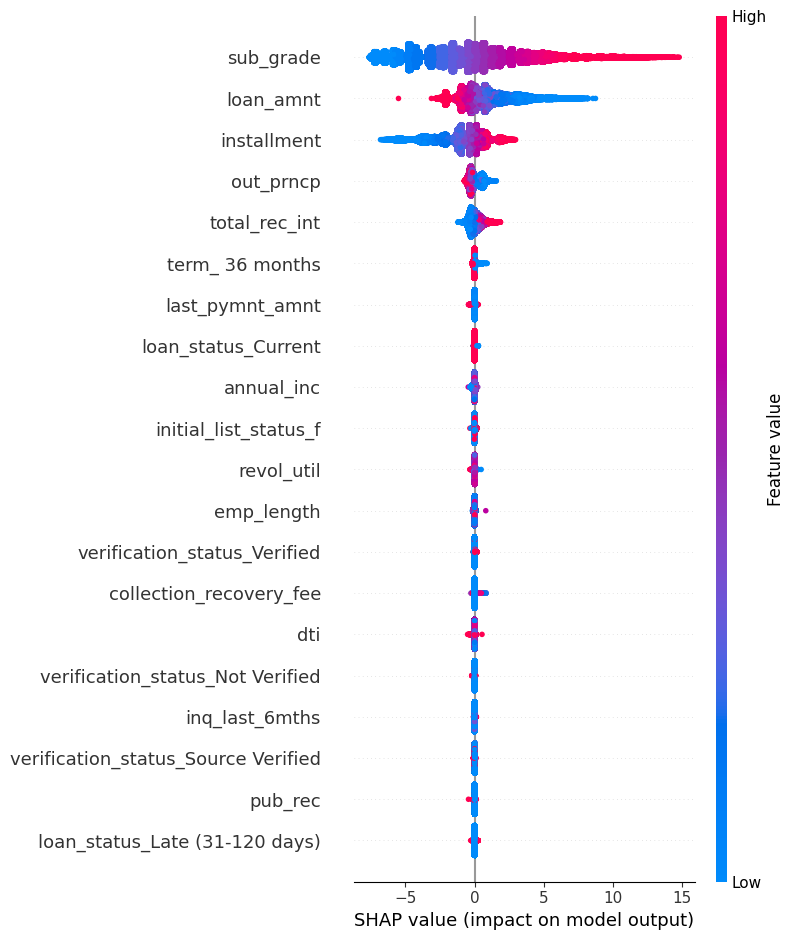


Displaying SHAP Summary Plot for the model without `sub_grade`...


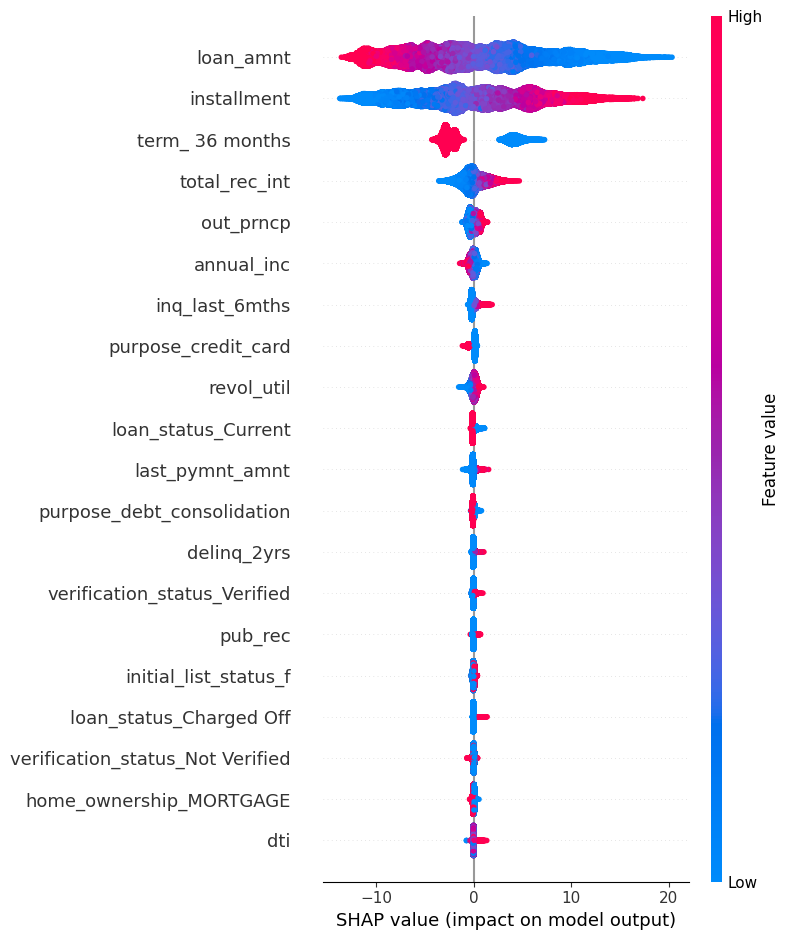


Displaying SHAP Bar Plot (Top 10 Features) for the model with `sub_grade`...


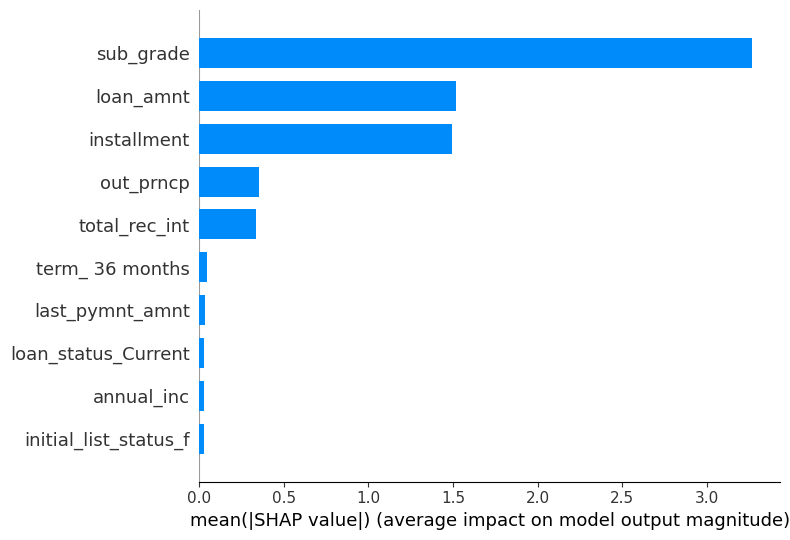


Displaying SHAP Bar Plot (Top 10 Features) for the model without `sub_grade`...


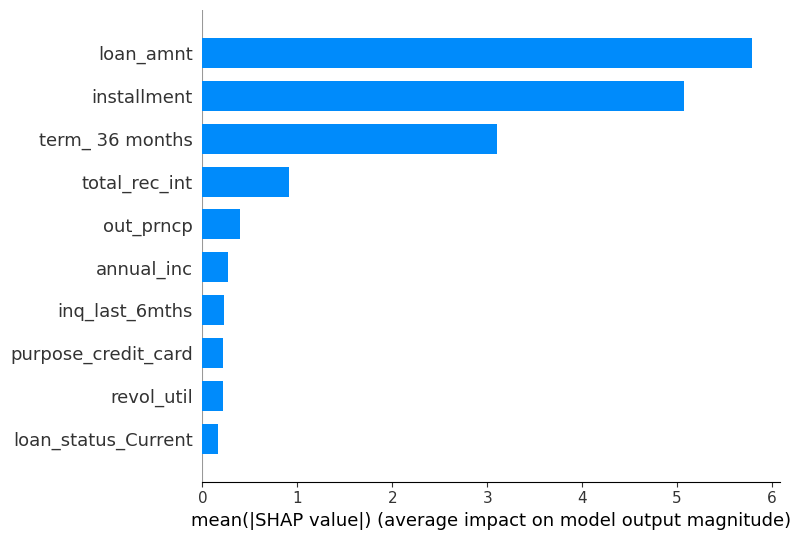


Displaying SHAP Waterfall Plot for instance 0 with `sub_grade`...


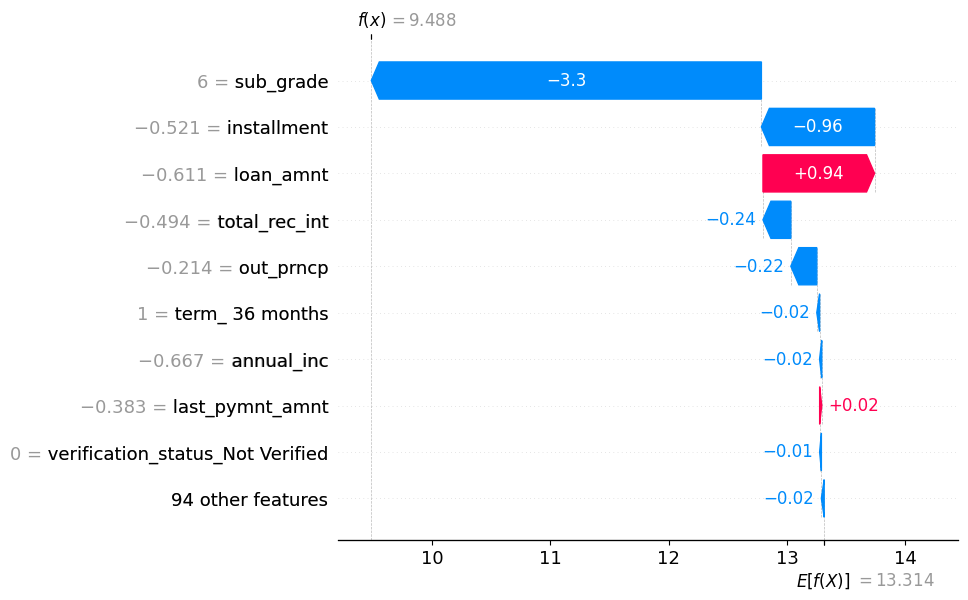


Displaying SHAP Waterfall Plot for instance 0 without `sub_grade`...


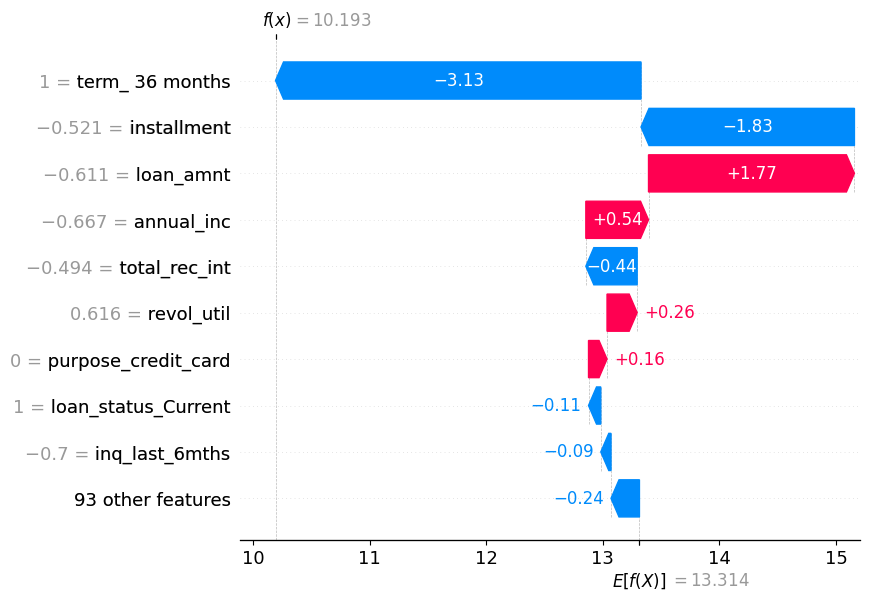

In [56]:
# Convert boolean columns to float for SHAP compatibility
X_train = X_train.astype(float)
X_train_without_sub_grade = X_train_without_sub_grade.astype(float)

# Set the background sample size to 100 for SHAP
X_train_background_with = X_train.sample(100, random_state=42)
X_train_background_without = X_train_without_sub_grade.sample(100, random_state=42)

# SHAP analysis for the model with `sub_grade`
print("\nPerforming SHAP analysis for the model with `sub_grade`...")
explainer_with_sub_grade = shap.TreeExplainer(xgb_with_sub_grade_final_model)
shap_values_with = explainer_with_sub_grade.shap_values(X_test)

# SHAP analysis for the model without `sub_grade`
print("\nPerforming SHAP analysis for the model without `sub_grade`...")
explainer_without_sub_grade = shap.TreeExplainer(xgb_without_sub_grade_final_model)
shap_values_without = explainer_without_sub_grade.shap_values(X_test_without_sub_grade)

# SHAP Summary Plot for the model with `sub_grade`
print("\nDisplaying SHAP Summary Plot for the model with `sub_grade`...")
shap.summary_plot(shap_values_with, X_test, feature_names=X_test.columns)

# SHAP Summary Plot for the model without `sub_grade`
print("\nDisplaying SHAP Summary Plot for the model without `sub_grade`...")
shap.summary_plot(shap_values_without, X_test_without_sub_grade, feature_names=X_test_without_sub_grade.columns)

# SHAP Bar Plot (Top 10 Features) for the model with `sub_grade`
print("\nDisplaying SHAP Bar Plot (Top 10 Features) for the model with `sub_grade`...")
shap.summary_plot(shap_values_with, X_test, feature_names=X_test.columns, plot_type="bar", max_display=10)

# SHAP Bar Plot (Top 10 Features) for the model without `sub_grade`
print("\nDisplaying SHAP Bar Plot (Top 10 Features) for the model without `sub_grade`...")
shap.summary_plot(shap_values_without, X_test_without_sub_grade, feature_names=X_test_without_sub_grade.columns, plot_type="bar", max_display=10)

# Optional: Waterfall plot for a specific instance (first test instance in this case)
instance_index = 0

# With sub_grade
print(f"\nDisplaying SHAP Waterfall Plot for instance {instance_index} with `sub_grade`...")
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_with[instance_index],
        base_values=explainer_with_sub_grade.expected_value,
        data=X_test.iloc[instance_index],
        feature_names=X_test.columns
    )
)

# Without sub_grade
print(f"\nDisplaying SHAP Waterfall Plot for instance {instance_index} without `sub_grade`...")
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_without[instance_index],
        base_values=explainer_without_sub_grade.expected_value,
        data=X_test_without_sub_grade.iloc[instance_index],
        feature_names=X_test_without_sub_grade.columns
    )
)

First XG Boost Model SHAP Analysis (With and Without Subgrade)

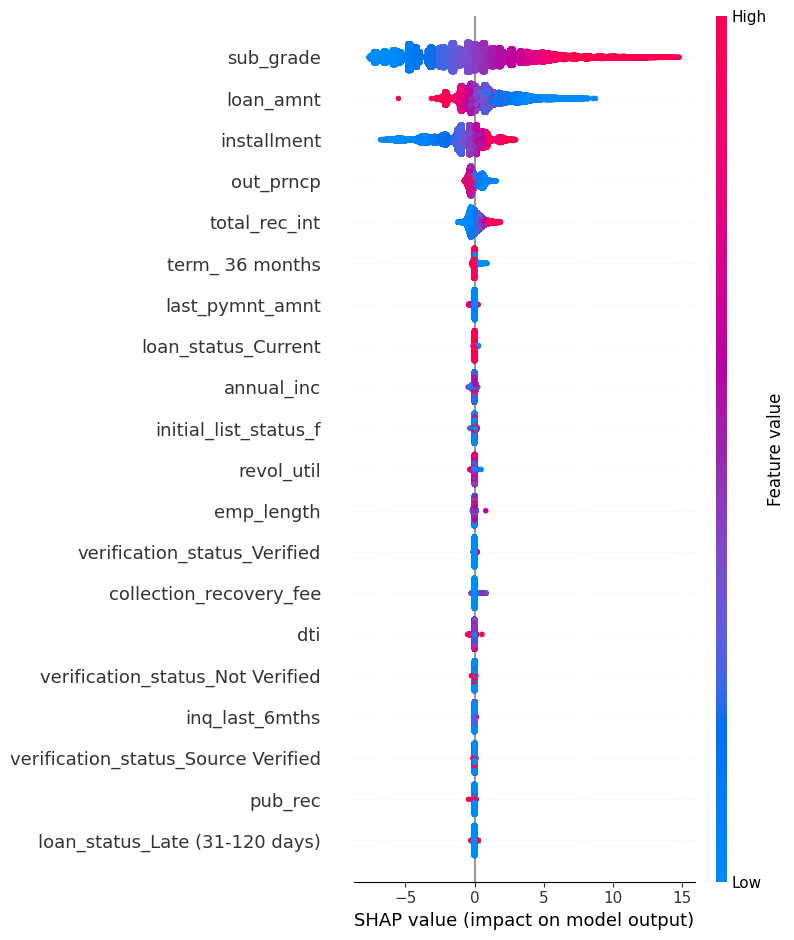

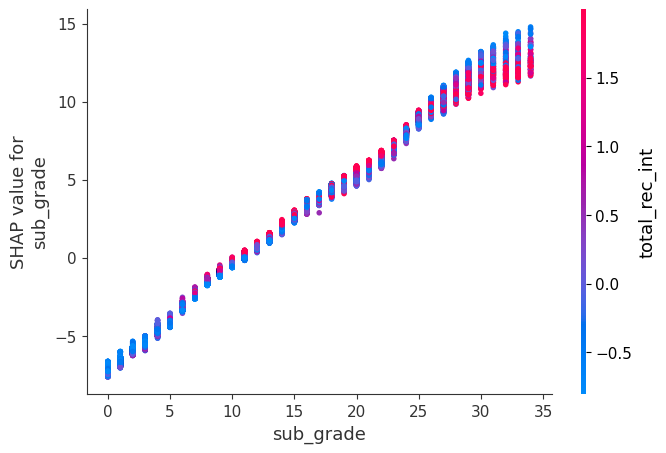

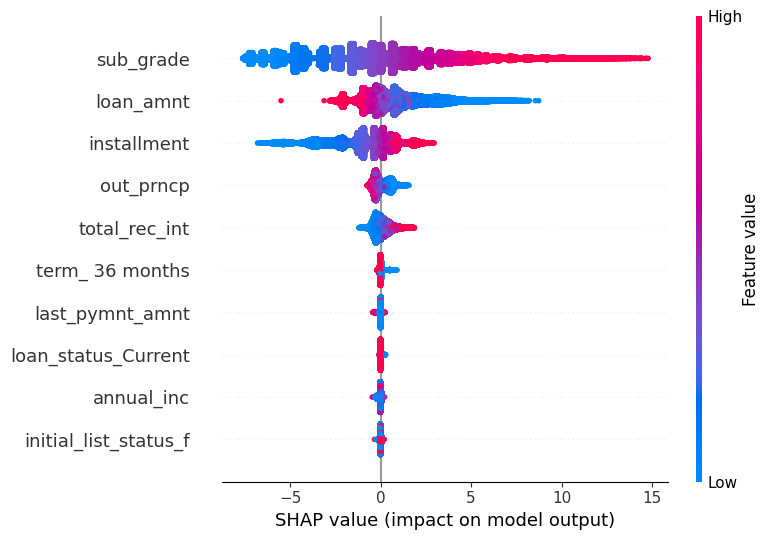

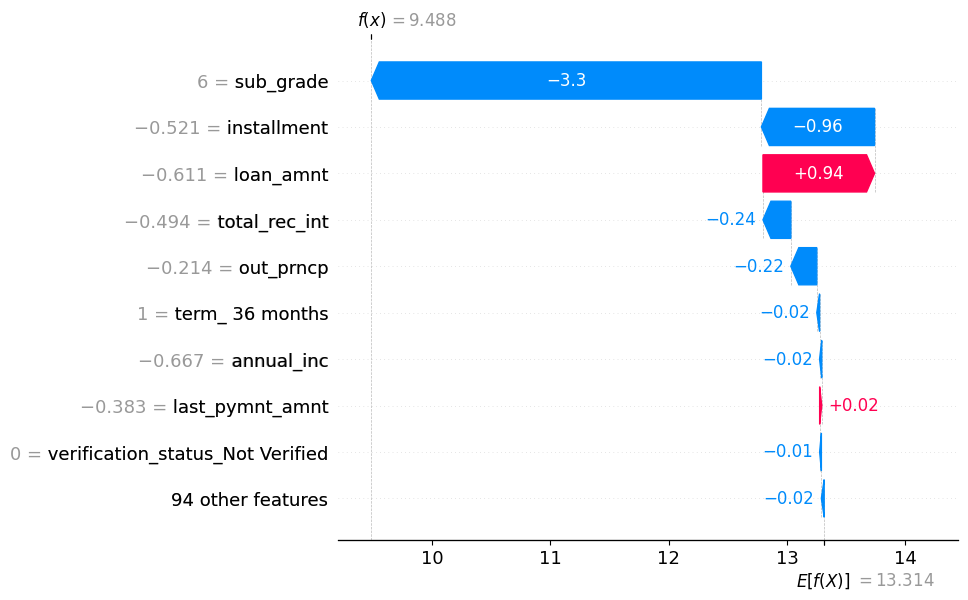

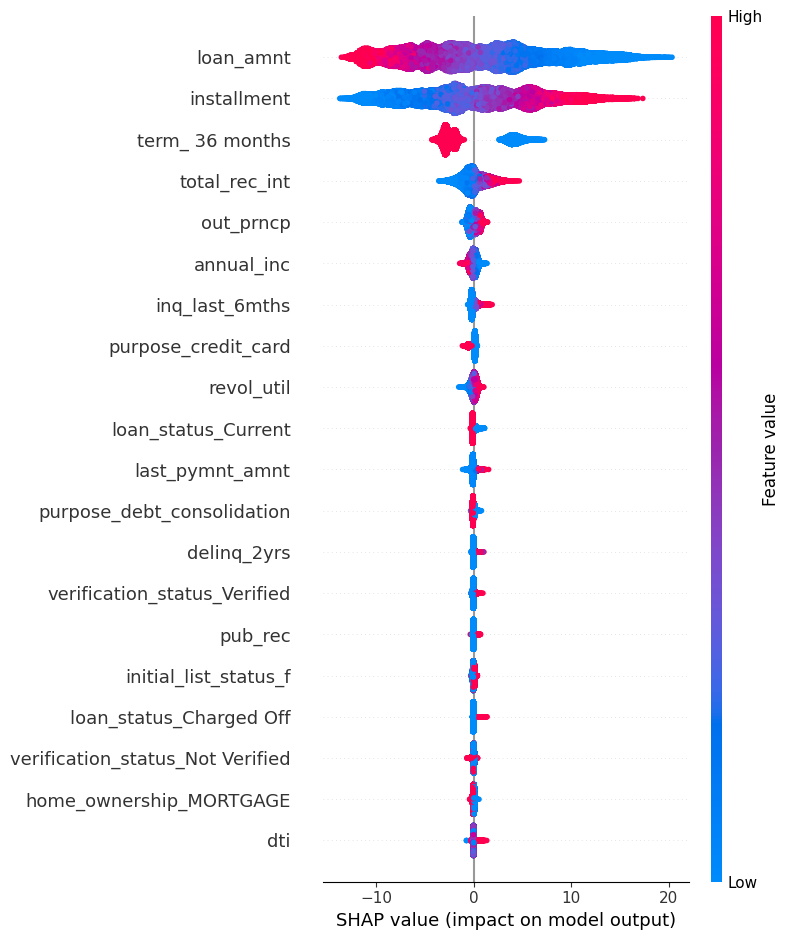

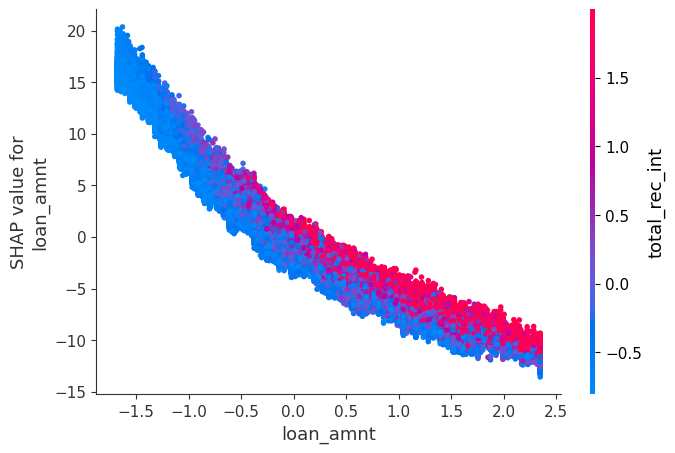

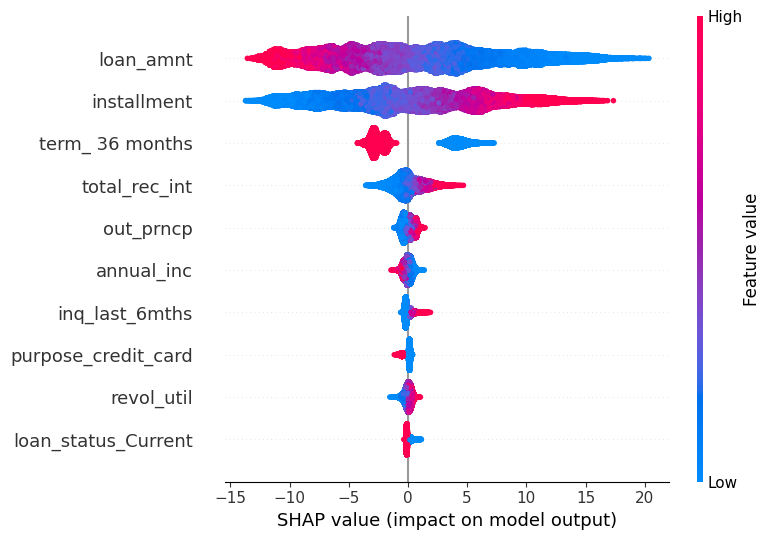

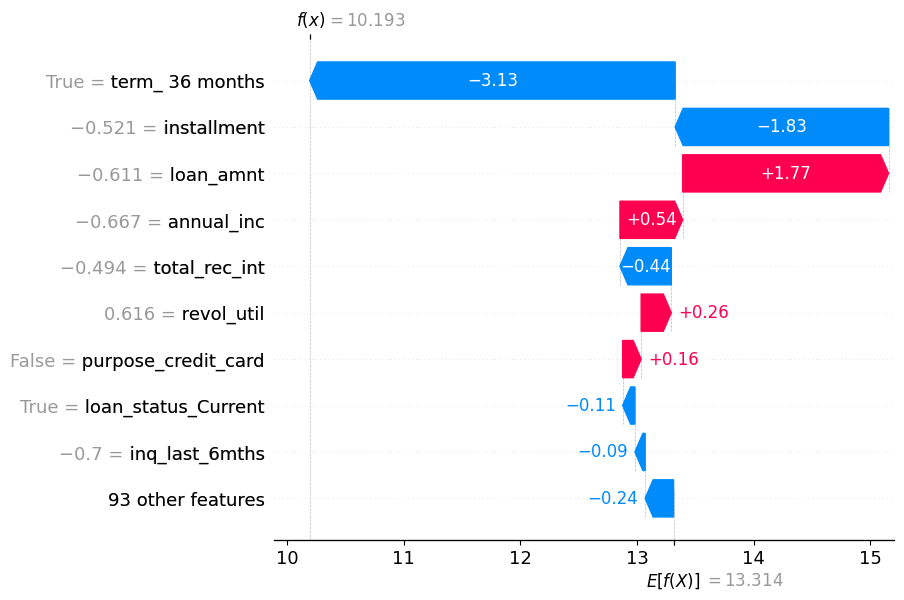

In [ ]:
# Use TreeExplainer for XGBoost model (more efficient for tree-based models)
explainer_with_sub_grade = shap.TreeExplainer(xgb_with_sub_grade)

# Compute SHAP values for the test set (without needing to sample again)
shap_values_with_sub_grade = explainer_with_sub_grade.shap_values(X_test)

# Visualize the SHAP Summary Plot for all features with sub_grade
shap.summary_plot(shap_values_with_sub_grade, X_test, feature_names=X_test.columns)

# Plot the dependence plot for 'sub_grade' feature
shap.dependence_plot('sub_grade', shap_values_with_sub_grade, X_test)

# SHAP Summary Plot showing the top 10 important features
shap.summary_plot(shap_values_with_sub_grade, X_test, feature_names=X_test.columns, max_display=10)

# Waterfall Plot for a specific instance (first test instance in this case)
instance_index = 0
instance_shap_values_with_sub_grade = shap_values_with_sub_grade[instance_index]

shap.waterfall_plot(
    shap.Explanation(
        values=instance_shap_values_with_sub_grade,
        base_values=explainer_with_sub_grade.expected_value,
        data=X_test.iloc[instance_index],
        feature_names=X_test.columns
    )
)

# Repeat SHAP analysis for the XGBoost model without `sub_grade`
explainer_without_sub_grade = shap.TreeExplainer(xgb_without_sub_grade)
shap_values_without_sub_grade = explainer_without_sub_grade.shap_values(X_test_without_sub_grade)

# SHAP Summary Plot for the model without `sub_grade`
shap.summary_plot(shap_values_without_sub_grade, X_test_without_sub_grade, feature_names=X_test_without_sub_grade.columns)

# Plot the dependence plot for a different feature (since `sub_grade` is not included)
shap.dependence_plot('loan_amnt', shap_values_without_sub_grade, X_test_without_sub_grade)

# SHAP Summary Plot showing the top 10 important features without sub_grade
shap.summary_plot(shap_values_without_sub_grade, X_test_without_sub_grade, feature_names=X_test_without_sub_grade.columns, max_display=10)

# Waterfall Plot for a specific instance (first test instance) without sub_grade
instance_shap_values_without_sub_grade = shap_values_without_sub_grade[instance_index]

shap.waterfall_plot(
    shap.Explanation(
        values=instance_shap_values_without_sub_grade,
        base_values=explainer_without_sub_grade.expected_value,
        data=X_test_without_sub_grade.iloc[instance_index],
        feature_names=X_test_without_sub_grade.columns
    )
)